In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/model/Copy of alexnet_allBN.h5')

conv2d (Conv2D)              11  
_________________________________________________________________
batch_normalization (BatchNo 11       
_________________________________________________________________
activation (Activation)      11       
_________________________________________________________________
max_pooling2d (MaxPooling2D) 22       
_________________________________________________________________
conv2d_1 (Conv2D)            22+5-1 = 26
_________________________________________________________________
batch_normalization_1 (Batch 26   
_________________________________________________________________
activation_1 (Activation)    26         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 52        
_________________________________________________________________
conv2d_2 (Conv2D)            54    
_________________________________________________________________
batch_normalization_2 (Batch 54      
_________________________________________________________________
activation_2 (Activation)    54         
_________________________________________________________________
conv2d_3 (Conv2D)            56  
_________________________________________________________________
batch_normalization_3 (Batch 56      
_________________________________________________________________
activation_3 (Activation)    56       
_________________________________________________________________
conv2d_4 (Conv2D)            58  
_________________________________________________________________
batch_normalization_4 (Batch 58     
_________________________________________________________________
activation_4 (Activation)    58       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 116        
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              51384320  
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_5 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_6 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_7 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_8 (Activation)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

In [ ]:
im = np.expand_dims(np.asarray(Image.open('/content/drive/My Drive/model/cat_224x224.jpg')),0)

In [ ]:
output = model(im)

In [ ]:
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow

def makeGaussian(size, fwhm = 100, center=None):
    """ 
    Adapt from Andrew Aiessel.
    Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, dtype='uint8'):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    """
    im = np.ones(imsize)
    # the last term is to make center phase 0.
    im = im*[np.sin(2*np.pi/spatialf*x+(phase/np.pi*180-2*np.pi/spatialf*imsize/2)) for x in range(imsize)]
    im = np.repeat(im[:,np.newaxis],imsize,axis=1)
    
    gaussianmask = makeGaussian(imsize, size)
    im = im*gaussianmask
    
    im = Image.fromarray(im)
    im = im.rotate(ori)
    
    im = (np.array(im)+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

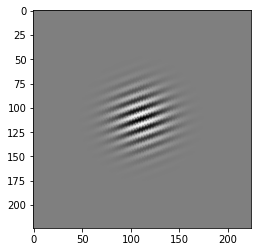

In [ ]:
grating = np.expand_dims(np.asarray(makeGrating(100, 60)),0)
imshow(makeGrating(45, 10, 200, 200), cmap='gray')

In [ ]:
grate = np.expand_dims(np.asarray(makeGrating(30, 10, 200, 200)),0)
intermediate_layer_activation_model = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_5').output)
layer = intermediate_layer_activation_model(grate, training=False).numpy()
# layer2 = intermediate_layer_activation_model(grating, training=False).numpy()
# print(layer[0,1000], layer2[0, 1000])

In [ ]:
grt1 = np.expand_dims(np.asarray(makeGrating(30, 4, 0, 0)),0)
grt2 = np.expand_dims(np.asarray(makeGrating(30, 60, 300, 0)),0)
lyr1 = intermediate_layer_activation_model(grt1, training=False).numpy()
lyr2 = intermediate_layer_activation_model(grt2, training=False).numpy()
print(lyr1[0, 1000], lyr2[0, 1000])

3.4808168 8.465821


In [ ]:
import pandas as pd

def find_optimal_grating(dimension):

  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray(makeGrating(30, i, j, k)),0)
        activation_layer = intermediate_layer_activation_model(inpt, training=False).numpy()
        n = activation_layer[0, dimension]
        phase.append(n)
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  return df[df.Average_phase==df.Average_phase.max()]

optimal1 = find_optimal_grating(500) 
print(optimal1)
optimal2 = find_optimal_grating(1000)
print(optimal2)
optimal3 = find_optimal_grating(1500)
print(optimal3)
optimal4 = find_optimal_grating(2000)
print(optimal4)
optimal5 = find_optimal_grating(2500)
print(optimal5)
optimal6 = find_optimal_grating(3000)
print(optimal6)
optimal7 = find_optimal_grating(3500)
print(optimal7)
optimal8 = find_optimal_grating(3700)
print(optimal8)
optimal9 = find_optimal_grating(4000)
print(optimal9)
optimal10 = find_optimal_grating(4500)
print(optimal10)
  

       Sf    Ori  Average_phase
0     4.0    0.0            0.0
1     4.0   45.0            0.0
2     4.0   90.0            0.0
3     4.0  135.0            0.0
4     4.0  180.0            0.0
..    ...    ...            ...
187  50.0  135.0            0.0
188  50.0  180.0            0.0
189  50.0  225.0            0.0
190  50.0  270.0            0.0
191  50.0  315.0            0.0

[192 rows x 3 columns]
       Sf    Ori  Average_phase
191  50.0  315.0       8.846139
       Sf  Ori  Average_phase
144  40.0  0.0      19.171078
       Sf  Ori  Average_phase
168  46.0  0.0       2.413519
     Sf    Ori  Average_phase
12  6.0  180.0        5.44854
    Sf    Ori  Average_phase
3  4.0  135.0       0.106995
    Sf   Ori  Average_phase
1  4.0  45.0      15.236813
       Sf    Ori  Average_phase
0     4.0    0.0            0.0
1     4.0   45.0            0.0
2     4.0   90.0            0.0
3     4.0  135.0            0.0
4     4.0  180.0            0.0
..    ...    ...            ...
187  50.0 

IndexError: ignored

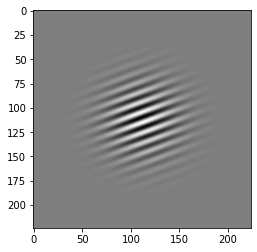

In [ ]:
# updated grating code
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow, figure

def makeGaussian(size, fwhm = 100, center=None):
    """ 
    Adapt from Andrew Aiessel.
    Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, dtype='uint8'):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    """
    ori = ori/180*np.pi
    im = np.ones((imsize,imsize))
    # the last term is to make center phase 0.
    phi = (phase/np.pi*180-2*np.pi/spatialf*imsize/2)
    for x in range(imsize):
        for y in range(imsize):
            im[x,y] = np.sin(2*np.pi/spatialf*((x*np.cos(ori)+y*np.sin(ori))+phi))           
    gaussianmask = makeGaussian(imsize, size)
    im = im*gaussianmask
    im = (im+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

imshow(makeGrating(60, 10, 200, 200))

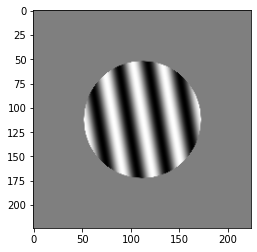

In [ ]:
# second grating update
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow, figure

def makeGaussian(size, radius=100, sharpness=5, center=None):
    """ 
    Make a square gaussian kernel.
    size is the length of a side of the square.
    inside radius, mask values are 1.
    from the radius to outside, there is a gaussian kernal with std=sharpness.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * (np.clip((x-x0)**2 + (y-y0)**2 - radius**2,0,None)) / sharpness**2)

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, dtype='uint8'):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    """
    ori = ori/180*np.pi
    im = np.ones((imsize,imsize))
    # the last term is to make center phase 0.
    phi = (phase/np.pi*180-2*np.pi/spatialf*imsize/2)
    for x in range(imsize):
        for y in range(imsize):
            im[x,y] = np.sin(2*np.pi/spatialf*((x*np.cos(ori)+y*np.sin(ori))+phi))           
    gaussianmask = makeGaussian(imsize, size)
    im = im*gaussianmask
    im = (im+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

imshow(makeGrating(60, 30, 100, 100))

In [ ]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path = '/content/drive/My Drive/model/'

training_data = []

for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        pic = makeGrating(30, i, j, k)
        training_data.append(pic)

np.save(os.path.join(path,'sharp_edge_grating'),np.array(training_data))
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
# plt.imshow(saved[0].reshape(80,80,3))
# plt.imshow(np.array(training_data[0]).reshape(80,80,3))




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
45
90
135
180
225
270
315


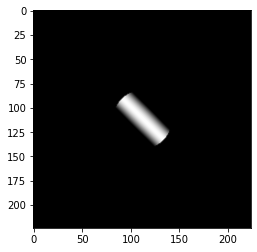

In [ ]:
#imshow(saved[0].reshape(224, 224, 3))
for i in range(0, 316, 45):
  print(i)

imshow(training_data_sharp[3005].reshape(224, 224, 3))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.083224066


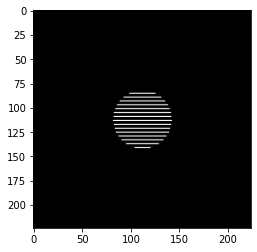

In [ ]:
pic = makeGrating(30, 20, 100, 100)
training_data.append(pic)

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation').output)
plt.imshow(np.array(saved[0]).reshape(224, 224, 3))
inpt = np.expand_dims(np.asarray((training_data[0]/127.5)-1),0)
activation_layer = intermediate_activation(inpt, training=False).numpy()
print(activation_layer[0, 28, 28, 50])

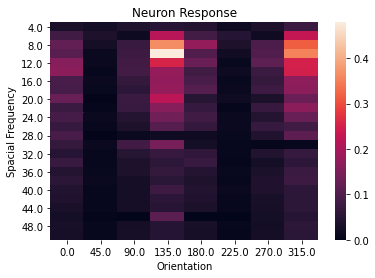

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation').output)

def find_optimal_grating(d1, d2, d3):

  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((makeGrating(30, i, j, k)/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, d1, d2, d3]
        phase.append(n)
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  ax = sns.heatmap(heatmap_data)
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation_response(freq, orient, d1, d2, d3):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, d1, d2, d3]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  plt.plot(x, y)
  plt.xlabel("size")
  plt.ylabel("reponse")
  plt.show()

sf1, ori1 = find_optimal_grating(28, 28, 10)


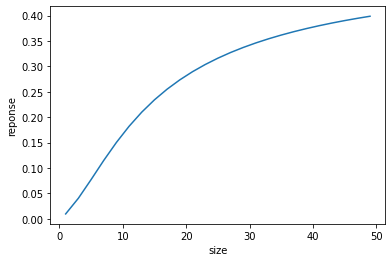

In [ ]:
size_variation_response(sf1, ori1, 28, 28, 10)

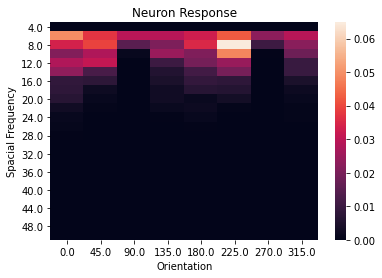

In [ ]:
sf2, ori2 = find_optimal_grating(28, 28, 45)

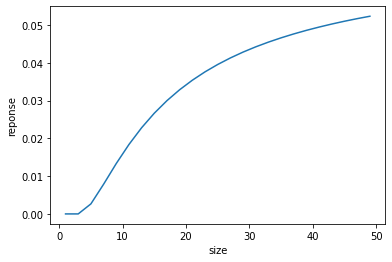

In [ ]:
size_variation_response(sf2, ori2, 28, 28, 45)

In [ ]:
sf3, ori3 = find_optimal_grating(28, 28, 90)

In [ ]:
size_variation_reponse(sf3, ori3, 28, 28, 90)

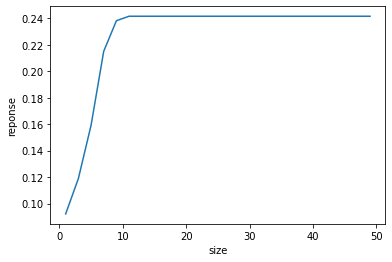

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))

  intermediate_activation = tf.keras.Model(inputs=model.input,
                                                    outputs=model.get_layer('activation').output)

  def find_optimal_grating(d1, d2, d3):
    l=0
    df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
    phase = []
    for i in range(4, 51, 2):
      for j in range(0, 316, 45):
        for k in range(0, 316, 45):
          inpt = np.expand_dims(np.asarray((saved[l]/127.5)-1),0)
          activation_layer = intermediate_activation(inpt, training=False).numpy()
          n = activation_layer[0, d1, d2, d3]
          phase.append(n)
          l+=1
        phase_avg = sum(phase)/len(phase)
        df.loc[len(df.index)] = [i, j, phase_avg]
        phase = []

    # heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
    # plt.subplot(1, 3, subplot)
    # ax = sns.heatmap(heatmap_data)
    # plt.xlabel("Orientation")
    # plt.ylabel("Spacial Frequency")
    # plt.title("Neuron Response")
    # plt.tight_layout()
    filtered =  df[df.Average_phase==df.Average_phase.max()]
    return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

  def size_variation_response(freq, orient, d1, d2, d3):
    x = []
    y = []
    phase = []
    for i in range(1, 50, 2):
      for j in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, d1, d2, d3]
        phase.append(n)
      phase_avg = sum(phase)/len(phase)
      x.append(i)
      y.append(phase_avg)
      phase = []

    plt.plot(x, y)
    plt.xlabel("size")
    plt.ylabel("reponse")
    plt.tight_layout

  sf1, ori1 = find_optimal_grating(28, 28, 8)
  size_variation_response(sf1, ori1, 28, 28, 8)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation').output
                                         
def find_optimal_grating(location):
  l=0
  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((saved[l]/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, 28, 28, location]
        phase.append(n)
        l+=1
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation_response(freq, orient, d1, d2, d3):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, d1, d2, d3]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  plt.plot(x, y)
  plt.xlabel("size")
  plt.ylabel("reponse")
  plt.tight_layout

sf1, ori1 = find_optimal_grating(50)
size_variation_response(sf1, ori1, 28, 28, 50)

SyntaxError: ignored

KeyboardInterrupt: ignored

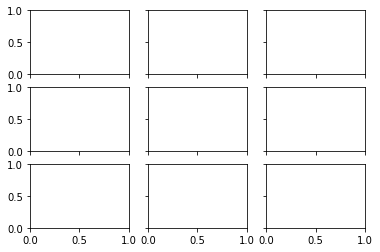

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_3').output)
count = 0
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow, figure

def makeGaussian(size, radius=100, sharpness=5, center=None):
    """ 
    Make a square gaussian kernel.
    size is the length of a side of the square.
    inside radius, mask values are 1.
    from the radius to outside, there is a gaussian kernal with std=sharpness.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * (np.clip((x-x0)**2 + (y-y0)**2 - radius**2,0,None)) / sharpness**2)

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, dtype='uint8'):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    """
    ori = ori/180*np.pi
    im = np.ones((imsize,imsize))
    # the last term is to make center phase 0.
    phi = (phase/np.pi*180-2*np.pi/spatialf*imsize/2)
    for x in range(imsize):
        for y in range(imsize):
            im[x,y] = np.sin(2*np.pi/spatialf*((x*np.cos(ori)+y*np.sin(ori))+phi))           
    gaussianmask = makeGaussian(imsize, size)
    im = im*gaussianmask
    im = (im+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

def size_variation(location):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, 4, 90, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)

  idx = y.index(max(y))
  return x[idx], x, y

def freq_variation(size, location):
  x = []
  y = []
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(size, i, 90, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)

  idx = y.index(max(y))
  return x[idx], x, y

def ori_variation(size, freq, location):
  x = []
  y = []
  phase = []
  for i in range(0, 316, 45):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(size, freq, i, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)

  return x, y

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
for x in range(3):
  num = random.randint(0, 383)
  max_size, x1, y1 = size_variation(num)
  ax[x, count].plot(x1, y1)
  count += 1
  max_freq, x2, y2 = freq_variation(max_size, num)
  ax[x, count].plot(x2, y2)
  count += 1
  x3, y3 = ori_variation(max_size, max_freq, num)
  ax[x, count].plot(x3, y3)
  count = 0







94
160
248
349
90


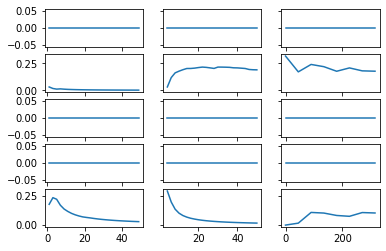

In [ ]:
fig, ax = plt.subplots(5, 3, sharex='col', sharey='row')
for x in range(5):
  num = random.randint(0, 383)
  print(num)
  max_size, x1, y1 = size_variation(num)
  ax[x, count].plot(x1, y1)
  count += 1
  max_freq, x2, y2 = freq_variation(max_size, num)
  ax[x, count].plot(x2, y2)
  count += 1
  x3, y3 = ori_variation(max_size, max_freq, num)
  ax[x, count].plot(x3, y3)
  count = 0

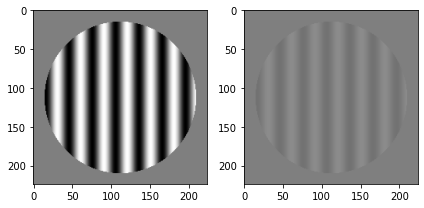

In [ ]:
# Annular Grating Update

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure

def makeGaussian(size, radius=100, sharpness=5, center=None, annular=0):
    """ 
    Make a square gaussian kernel.
    size is the length of a side of the square.
    inside radius, mask values are 1.
    outside the radius, there is a gaussian kernal with FWHM=sharpness.
    inside annular, it is reversed gaussian, i.e. decrease to 0. For annular 
    stimuli, i.e. donuts.
    """
    
    assert radius > (sharpness/2)
    assert annular < radius
    
    radius = radius - sharpness/2
    
    if annular > sharpness/2:
        annular = annular - sharpness/2
    
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    if sharpness != 0:
        outer_gaussian = np.exp(-4*np.log(2) * (np.clip((x-x0)**2 + (y-y0)**2 - radius**2,0,None)) / sharpness**2)
    else:
        outer_gaussian = np.heaviside(-(x-x0)**2 - (y-y0)**2 + radius**2, 0.5)
    
    if annular>0:
        if sharpness != 0:
            inner_gaussian = np.exp(-4*np.log(2) * (np.clip(-(x-x0)**2 - (y-y0)**2 + annular**2,0,None)) / sharpness**2)
        else:
            inner_gaussian = np.heaviside((x-x0)**2 + (y-y0)**2 - annular**2, 0.5)
        return inner_gaussian * outer_gaussian
    return outer_gaussian

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, sharpness=5, contrast=1, annular=0, dtype='uint8'):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    annular: inside diameter of the donut.
    sharpness: pixels of HMFW of gaussian mask.
    contrast: 0-1.
    """
    ori = ori/180*np.pi
    im = np.ones((imsize,imsize))
    # the last term is to make center phase 0.
    phi = (phase/np.pi*180-2*np.pi/spatialf*imsize/2)
    for x in range(imsize):
        for y in range(imsize):
            im[x,y] = np.sin(2*np.pi/spatialf*((x*np.cos(ori)+y*np.sin(ori))+phi))           
    gaussianmask = makeGaussian(imsize, size, sharpness, annular=annular)
    im = im*gaussianmask*contrast
    im = (im+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

fig, ax = plt.subplots(1, 2)
ax[0].imshow(makeGrating(100, 30, 90, 0, contrast=1))
ax[1].imshow(makeGrating(100, 30, 90, 0, contrast=0.1))
plt.tight_layout()


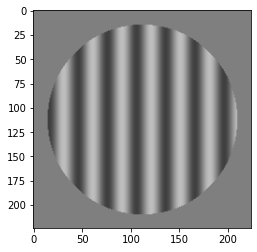

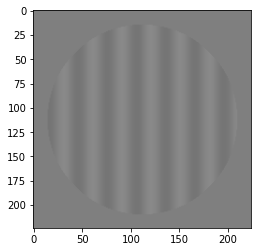

In [ ]:
plt.figure()
imshow(makeGrating(100, 30, 90, 0, contrast=0.5))
plt.figure()
imshow(makeGrating(100, 30, 90, 0, contrast=0.08))

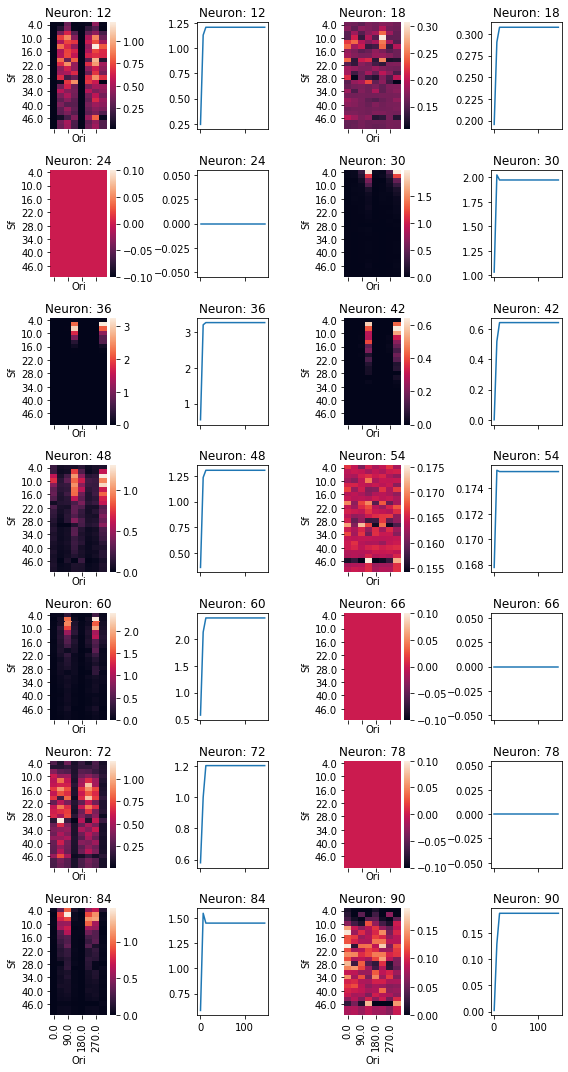

In [ ]:
count = 0
num = 0
path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(12, 96, 6).tolist()
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation1_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(1, 150, 6):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 28, 28, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  idx = y.index(max(y))
  return x[idx], x, y


fig, ax = plt.subplots(7, 4, sharex='col', figsize=(8, 15))
for x in range(7):
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    num += 1
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count = 0
    num += 1
plt.tight_layout()
plt.savefig(f"{path}/layer_response/activation1.png")
plt.show()



Text(0.5, 0, 'Stimulus Radius')

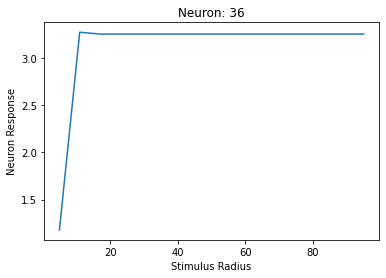

In [ ]:
import pandas as pd
import seaborn as sns
import os

path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(12, 96, 6).tolist()
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation1_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(5, 100, 6):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 28, 28, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  return x, y

plt.figure()
sf, ori= find_optimal_grating(36)
x1, y1 = size_variation(sf, ori, 36)
plt.plot(x1, y1)
plt.title(f"Neuron: 36")
plt.ylabel("Neuron Response")
plt.xlabel("Stimulus Radius")


Text(0.5, 0, 'Stimulus Radius')

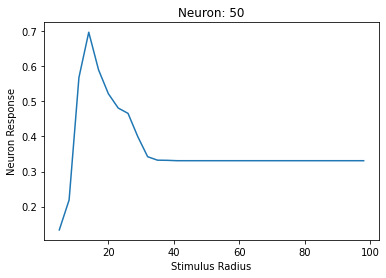

In [ ]:
import pandas as pd
import seaborn as sns
import os

path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(5, 100, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  return x, y

plt.figure()
sf, ori= find_optimal_grating(50)
x1, y1 = size_variation(sf, ori, 50)
plt.plot(x1, y1)
plt.title(f"Neuron: 50")
plt.ylabel("Neuron Response")
plt.xlabel("Stimulus Radius")

Text(0.5, 0, 'Stimulus Radius')

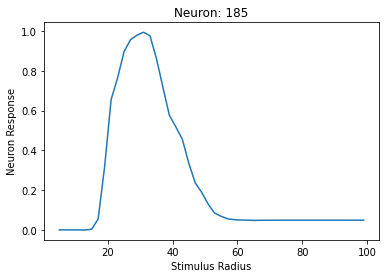

In [ ]:
import pandas as pd
import seaborn as sns
import os

path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(12, 96, 6).tolist()
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(5, 100, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  return x, y

plt.figure()
sf, ori= find_optimal_grating(185)
x1, y1 = size_variation(sf, ori, 185)
plt.plot(x1, y1)
plt.title(f"Neuron: 185")
plt.ylabel("Neuron Response")
plt.xlabel("Stimulus Radius")

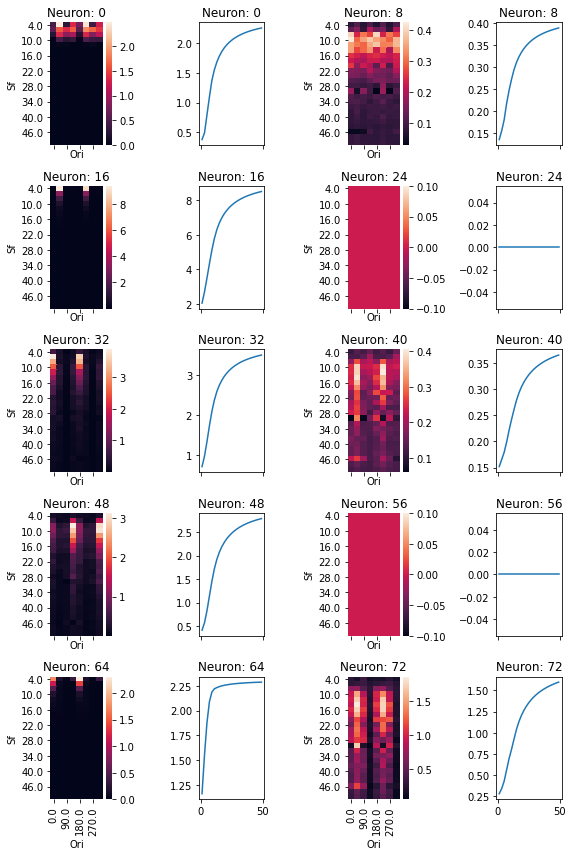

<Figure size 432x288 with 0 Axes>

In [ ]:
count = 0
num = 0
path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(0, 96, 8).tolist()

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('max_pooling2d').output)
def find_optimal_grating(location):
  l=0
  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((saved[l]/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, 14, 14, location]
        phase.append(n)
        l+=1
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  idx = y.index(max(y))
  return x[idx], x, y

fig, ax = plt.subplots(5, 4, sharex='col', figsize=(8, 12))
for x in range(5):
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    num += 1
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count = 0
    num += 1
plt.tight_layout()
plt.show()
plt.savefig(f"{path}/layer_response/maxpooling1.png")

In [ ]:
import os
path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))


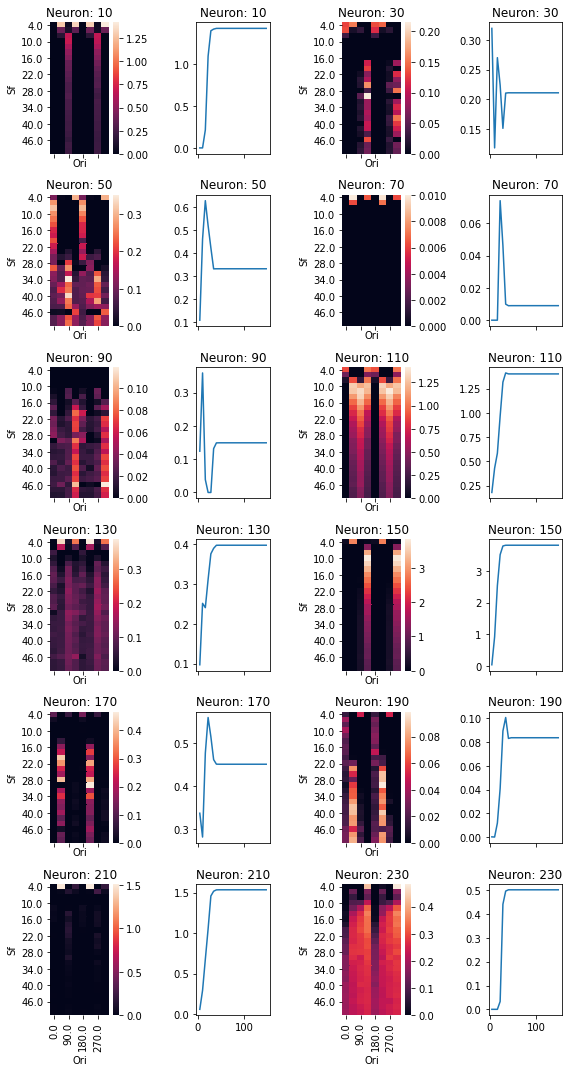

In [ ]:
count = 0
num = 0
path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(10, 250, 20).tolist()
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(4, 150, 6):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  idx = y.index(max(y))
  return x[idx], x, y


fig, ax = plt.subplots(6, 4, sharex='col', figsize=(8, 15))
for x in range(6):
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    num += 1
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count = 0
    num += 1
plt.tight_layout()
plt.savefig(f"{path}/layer_response/activation2.png")
plt.show()

Text(33.0, 0.5, 'Spacial Frequency')

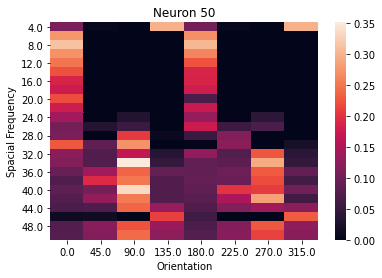

In [ ]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

plt.figure()
sf, ori, pivot_data = find_optimal_grating(50)
sns.heatmap(pivot_data)
plt.title("Neuron 50")
plt.xlabel("Orientation")
plt.ylabel("Spacial Frequency")

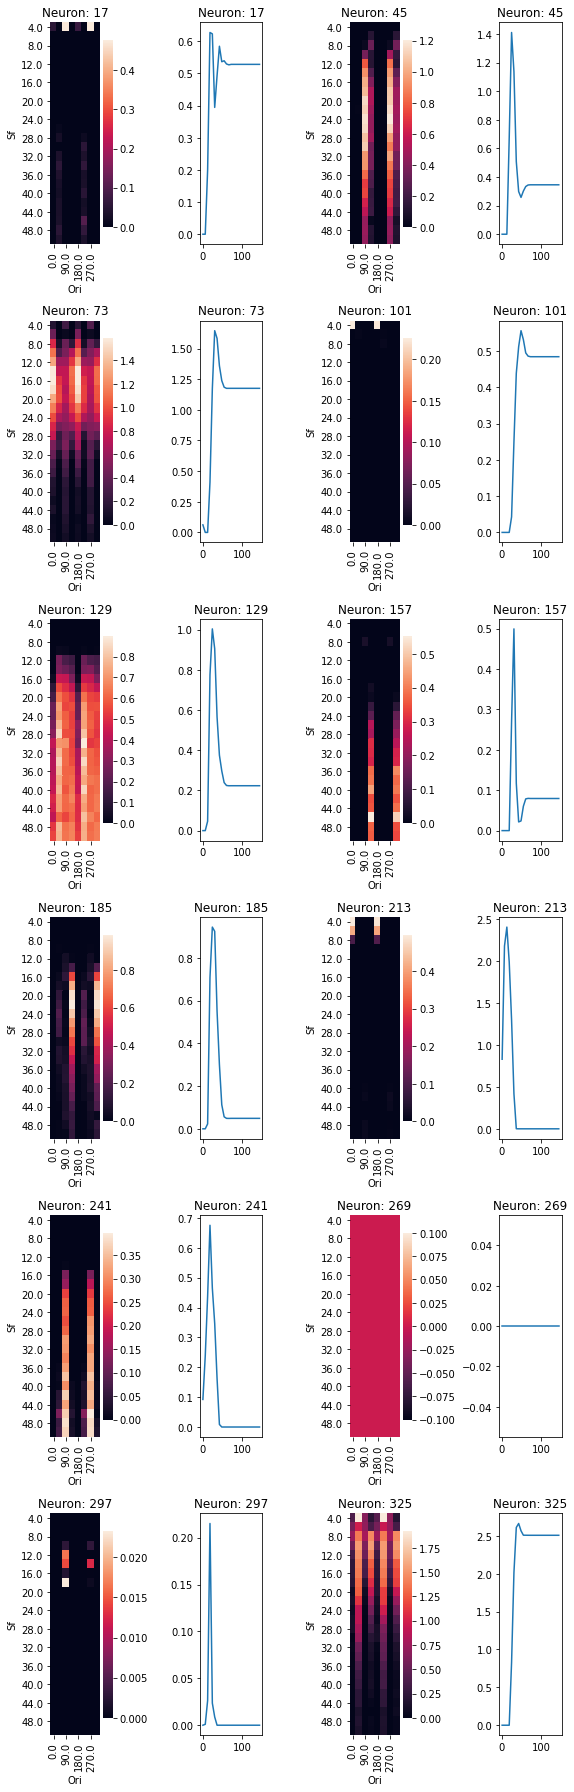

In [ ]:
count = 0
num = 0
path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(17, 353, 28).tolist()
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(1, 150, 6):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  idx = y.index(max(y))
  return x[idx], x, y


fig, ax = plt.subplots(6, 4, figsize=(8, 25))
for x in range(6):
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    num += 1
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count = 0
    num += 1
plt.tight_layout()
plt.savefig(f"{path}/layer_response/activation2.png")
plt.show()

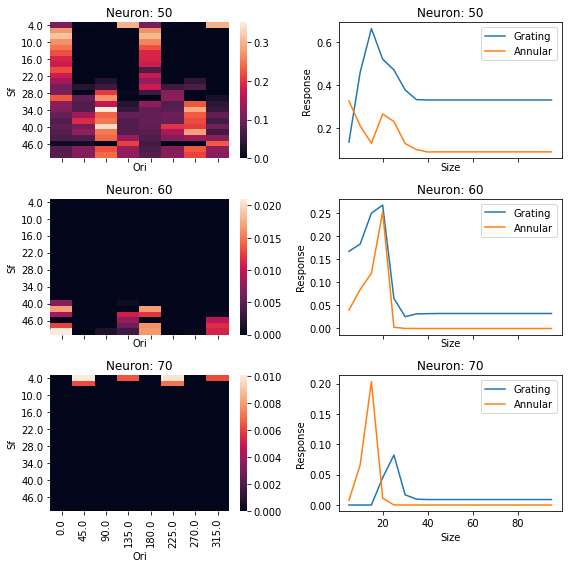

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = [50, 60, 70]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(100, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []


  return x, y1, y2


fig, ax = plt.subplots(3, 2, sharex='col', figsize=(8, 8))
for x in range(3):
  sf, ori, pivot_data = find_optimal_grating(neurons[x])
  sns.heatmap(pivot_data, ax=ax[x, count])
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count += 1
  x1, y1, y2 = size_variation(sf, ori, neurons[x])
  ax[x, count].plot(x1, y1, label = 'Grating')
  ax[x, count].plot(x1, y2, label = 'Annular')
  ax[x, count].set_xlabel("Size")
  ax[x, count].set_ylabel("Response")
  ax[x, count].legend()
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count = 0
plt.tight_layout()
plt.savefig(f"{path}/annular_response/activation2.png")
plt.show()

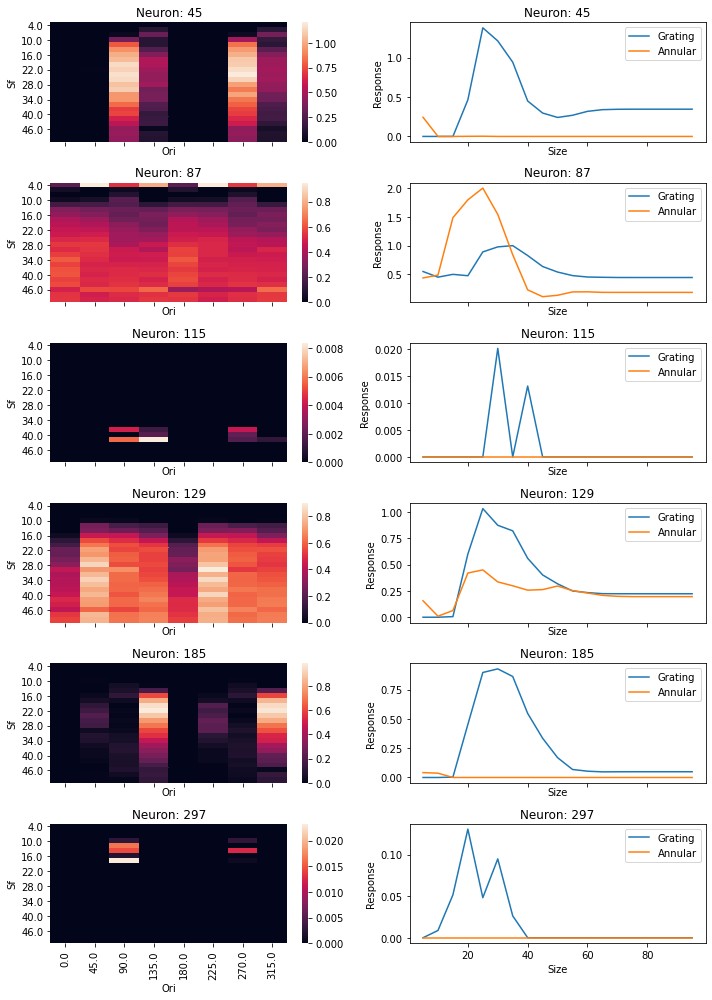

In [ ]:
count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)
neurons = [45, 87, 101, 129, 185, 213]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(100, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  return x, y1, y2

fig, ax = plt.subplots(6, 2, sharex='col', figsize=(10, 14))
for x in range(6):
  sf, ori, pivot_data = find_optimal_grating(neurons[x])
  sns.heatmap(pivot_data, ax=ax[x, count])
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count += 1
  x1, y1, y2 = size_variation(sf, ori, neurons[x])
  ax[x, count].plot(x1, y1, label = 'Grating')
  ax[x, count].plot(x1, y2, label = 'Annular')
  ax[x, count].set_xlabel("Size")
  ax[x, count].set_ylabel("Response")
  ax[x, count].legend()
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count = 0
plt.tight_layout()
plt.savefig(f"{path}/annular_response/activation3.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


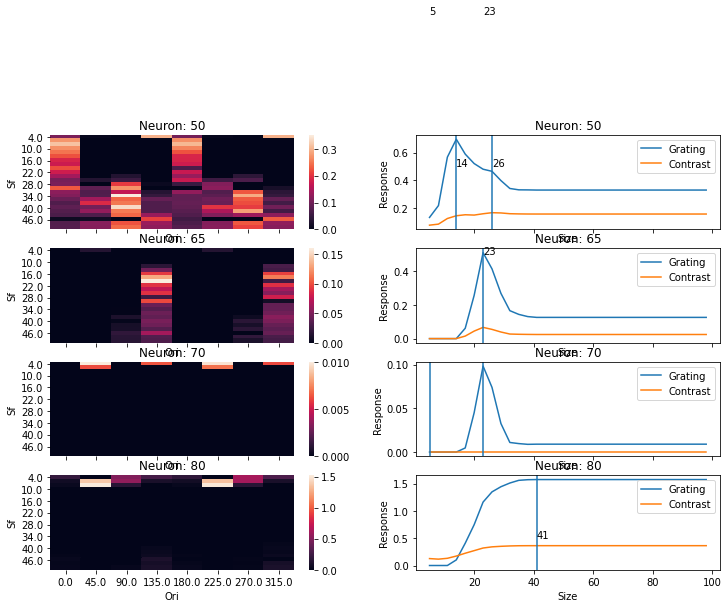

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = [50, 65, 70, 80]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 100, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(5, 100, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast=0.1)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  grate_idx = y1.index(max(y1))
  contrast_idx = y2.index(max(y2))
  return x, y1, y2, grate_idx, contrast_idx


fig, ax = plt.subplots(4, 2, sharex='col', figsize=(12, 8))
for x in range(4):
  sf, ori, pivot_data = find_optimal_grating(neurons[x])
  sns.heatmap(pivot_data, ax=ax[x, count])
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count += 1
  x1, y1, y2, max_y1, max_y2 = size_variation(sf, ori, neurons[x])
  ax[x, count].plot(x1, y1, label = 'Grating')
  ax[x, count].plot(x1, y2, label = 'Contrast')
  if max_y1 == max_y2:
    ax[x, count].axvline(x1[max_y1])
    ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
  else:
    ax[x, count].axvline(x1[max_y1])
    ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
    ax[x, count].axvline(x1[max_y2])
    ax[x, count].text(x1[max_y2], 0.5, x1[max_y2])
  ax[x, count].set_xlabel("Size")
  ax[x, count].set_ylabel("Response")
  ax[x, count].legend()
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count = 0
plt.tight_layout()
plt.show()

In [ ]:
y1.index(max(y1))
print(x1[12])

41


Neuron 45 Suppression Index: 0.8339128366238846
Neuron 101 Suppression Index: 0.04429411810521988
Neuron 129 Suppression Index: 0.5909253482063986
Neuron 185 Suppression Index: 0.6497486262329848
Neuron 297 Suppression Index: 1.0


IndexError: ignored

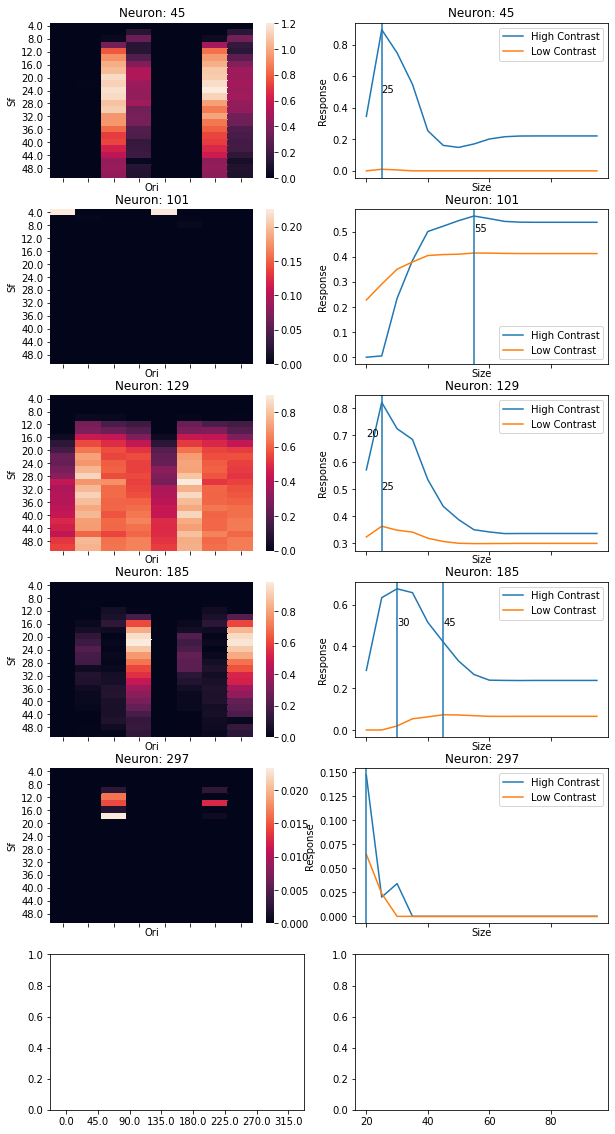

In [ ]:
import pandas as pd
import seaborn as sns
count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)
neurons = [45, 101, 129, 185, 297]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(20, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast = 0.5)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(20, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast = 0.08)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  # dtc: diameter tunning curve.
  max_index = np.argmax(y1)
  max_r = np.max(y1)
  suppress_r = np.min(y1[max_index:])
  suppress_idx =  1-suppress_r/max_r
  print(f'Neuron {location} Suppression Index: {suppress_idx}')

  grate_idx = y1.index(max(y1))
  contrast_idx = y2.index(max(y2))
  return x, y1, y2, grate_idx, contrast_idx, suppress_idx

fig, ax = plt.subplots(6, 2, sharex='col', figsize=(10, 20))
for x in range(6):
  sf, ori, pivot_data = find_optimal_grating(neurons[x])
  sns.heatmap(pivot_data, ax=ax[x, count])
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count += 1
  x1, y1, y2, max_y1, max_y2, suppress = size_variation(sf, ori, neurons[x])
  ax[x, count].plot(x1, y1, label = 'High Contrast')
  ax[x, count].plot(x1, y2, label = 'Low Contrast')
  if max_y1 == max_y2:
    ax[x, count].axvline(x1[max_y1])
    ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
  else:
    ax[x, count].axvline(x1[max_y1])
    ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
    ax[x, count].axvline(x1[max_y2])
    ax[x, count].text(x1[max_y2], 0.5, x1[max_y2])
  ax[x, count].set_xlabel("Size")
  ax[x, count].set_ylabel("Response")
  ax[x, count].legend()
  ax[x, count].set_title(f"Neuron: {neurons[x]}")
  count = 0
plt.tight_layout()
plt.show()

Neuron 185 Suppression Index: 0.6497486262329848


Text(0.5, 1.0, 'Neuron: 185')

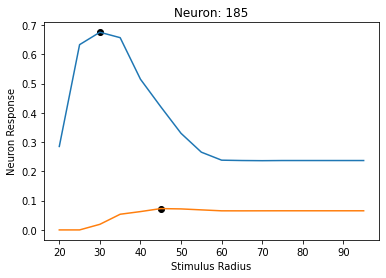

In [ ]:
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(20, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast = 0.5)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(20, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast = 0.08)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  # dtc: diameter tunning curve.
  max_index = np.argmax(y1)
  max_r = np.max(y1)
  suppress_r = np.min(y1[max_index:])
  suppress_idx =  1-suppress_r/max_r
  print(f'Neuron {location} Suppression Index: {suppress_idx}')

  grate_idx = y1.index(max(y1))
  grate_max = max(y1)
  contrast_idx = y2.index(max(y2))
  contrast_max = max(y2)
  return x, y1, y2, grate_idx, contrast_idx, grate_max, contrast_max

plt.figure()
sf, ori = find_optimal_grating(185)
x1, y1, y2, idx_y1, idx_y2, max_y1, max_y2 = size_variation(sf, ori, 185)
max_x = [x1[idx_y1], x1[idx_y2]]
max_y = [max_y1, max_y2]
plt.plot(x1, y1, label = 'High Contrast')
plt.plot(x1, y2, label = 'Low Contrast')
plt.scatter(max_x, max_y, color='black')
plt.xlabel("Stimulus Radius")
plt.ylabel("Neuron Response")
plt.title(f"Neuron: 185")

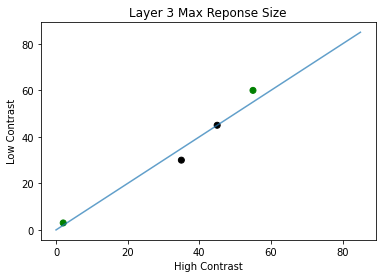

In [ ]:
x = np.arange(0, 90, 5)
y = x
x1 = [2, 55, 45, 35]
x2 = [3, 60, 45, 30]
colors = []
for i in range(4):
  if x1[i] < x2[i]:
    colors.append('green')
  else:
    colors.append('black')
plt.figure()
plt.plot(x, y, alpha=0.7)
plt.xlabel("High Contrast")
plt.ylabel("Low Contrast")
plt.title("Layer 3 Max Reponse Size")
plt.scatter(x1, x2, c=colors)
plt.show()

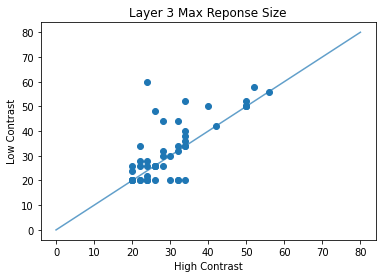

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

max_hc_response = []
max_lc_response = []
colors = []
count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)

neurons = np.arange(10, 361, 7)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(20, 80, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast = 0.5)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(20, 80, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j, contrast = 0.09)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  hc_idx = y1.index(max(y1))
  lc_idx = y2.index(max(y2))
  return x[hc_idx], x[lc_idx]

# fig, ax = plt.subplots(6, 2, sharex='col', figsize=(10, 20))
# for x in range(6):
#   sf, ori, pivot_data = find_optimal_grating(neurons[x])
#   sns.heatmap(pivot_data, ax=ax[x, count])
#   ax[x, count].set_title(f"Neuron: {neurons[x]}")
#   count += 1
#   x1, y1, y2, max_y1, max_y2, suppress = size_variation(sf, ori, neurons[x])
#   ax[x, count].plot(x1, y1, label = 'Grating')
#   ax[x, count].plot(x1, y2, label = 'Contrast')
#   if max_y1 == max_y2:
#     ax[x, count].axvline(x1[max_y1])
#     ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
#   else:
#     ax[x, count].axvline(x1[max_y1])
#     ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
#     ax[x, count].axvline(x1[max_y2])
#     ax[x, count].text(x1[max_y2], 0.5, x1[max_y2])
#   ax[x, count].set_xlabel("Size")
#   ax[x, count].set_ylabel("Response")
#   ax[x, count].legend()
#   ax[x, count].set_title(f"Neuron: {neurons[x]}")
#   count = 0
# plt.tight_layout()
# plt.show()

for i in range(51):
  sf, ori = find_optimal_grating(neurons[i])
  hc, lc = size_variation(sf, ori, neurons[i])
  max_hc_response.append(hc)
  max_lc_response.append(lc)
x = np.arange(0, 85, 5)
y = x
plt.figure()
plt.scatter(max_hc_response, max_lc_response)
plt.plot(x, y, alpha=0.7)
plt.xlabel("High Contrast")
plt.ylabel("Low Contrast")
plt.title("Layer 3 Max Reponse Size")
plt.axis('square') # make axis square
plt.show()


In [ ]:
print(max_hc_response)
print(max_lc_response)

[28, 26, 34, 26, 50, 26, 30, 22, 24, 34, 32, 34, 24, 56, 50, 20, 28, 26, 24, 28, 22, 34, 52, 32, 30, 32, 50, 26, 40, 20, 22, 24, 24, 20, 22, 22, 32, 20, 28, 24, 50, 20, 34, 24, 20, 42, 34, 20, 34, 26, 32]
[32, 48, 20, 26, 50, 26, 20, 34, 28, 52, 20, 36, 22, 56, 50, 20, 26, 26, 20, 44, 28, 34, 58, 20, 30, 44, 50, 26, 50, 24, 20, 60, 26, 20, 20, 26, 32, 20, 30, 20, 52, 20, 34, 20, 26, 42, 38, 20, 40, 20, 34]


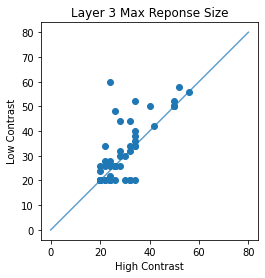

In [ ]:
x = np.arange(0, 85, 5)
y = x
max_hc_response = [28, 26, 34, 26, 50, 26, 30, 22, 24, 34, 32, 34, 24, 56, 50, 20, 28, 26, 24, 28, 22, 34, 52, 32, 30, 32, 50, 26, 40, 20, 22, 24, 24, 20, 22, 22, 32, 20, 28, 24, 50, 20, 34, 24, 20, 42, 34, 20, 34, 26, 32]
max_lc_response = [32, 48, 20, 26, 50, 26, 20, 34, 28, 52, 20, 36, 22, 56, 50, 20, 26, 26, 20, 44, 28, 34, 58, 20, 30, 44, 50, 26, 50, 24, 20, 60, 26, 20, 20, 26, 32, 20, 30, 20, 52, 20, 34, 20, 26, 42, 38, 20, 40, 20, 34]
plt.figure()
plt.scatter(max_hc_response, max_lc_response)
plt.plot(x, y, alpha=0.7)
plt.xlabel("High Contrast")
plt.ylabel("Low Contrast")
plt.title("Layer 3 Max Reponse Size")
plt.axis('square') # make axis square
plt.show()

In [ ]:
import pandas as pd

activation2_suppress = []

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons2 = np.arange(5, 145, 5)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(20, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y1.append(phase_avg)
    phase = []

  # dtc: diameter tunning curve.
  max_index = np.argmax(y1)
  max_r = np.max(y1)
  suppress_r = np.min(y1[max_index:])
  suppress_idx =  1-suppress_r/max_r
  return suppress_idx
  # grate_idx = y1.index(max(y1))
  # contrast_idx = y2.index(max(y2))
  # return x, y1, y2, grate_idx, contrast_idx, suppress_idx

for x in range(28):
  sf, ori = find_optimal_grating(neurons2[x])
  sup = size_variation(sf, ori, neurons2[x])
  activation2_suppress.append(sup)

In [ ]:
activation2_suppress

[0.31924939709876576,
 0.003940811013614431,
 0.14184725844128254,
 0.0,
 0.00176965487524261,
 0.388355483230032,
 0.0,
 0.01505070462326008,
 0.0008978816894741337,
 0.36592212192245543,
 0.0833388531980287,
 0.9045597034803813,
 0.7300603194010126,
 0.890988623085381,
 0.005415722695309433,
 0.00022694093117681113,
 0.1419214165824786,
 0.0,
 0.00017506961684343736,
 0.002783345538739157,
 0.22648938672330687,
 0.004151943189007801,
 0.49182761227346317,
 0.1942150489844362,
 0.00017950560629864665,
 0.0,
 0.3860153315484397,
 0.11357314851324563]

In [ ]:
import pandas as pd

activation3_suppress = []

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)
neurons2 = np.arange(10, 332, 14)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(20, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y1.append(phase_avg)
    phase = []

  # dtc: diameter tunning curve.
  max_index = np.argmax(y1)
  max_r = np.max(y1)
  suppress_r = np.min(y1[max_index:])
  suppress_idx =  1-suppress_r/max_r
  return suppress_idx
  # grate_idx = y1.index(max(y1))
  # contrast_idx = y2.index(max(y2))
  # return x, y1, y2, grate_idx, contrast_idx, suppress_idx

for x in range(23):
  sf, ori = find_optimal_grating(neurons2[x])
  sup = size_variation(sf, ori, neurons2[x])
  activation3_suppress.append(sup)

In [ ]:
activation3_suppress

[0.6714527817042157,
 1.0,
 0.16295779863991078,
 1.0,
 0.8782416873621564,
 1.0,
 0.8932672105545252,
 0.3079867692339626,
 1.0,
 1.0,
 1.0,
 0.3063188071637635,
 0.29859988698864626,
 0.012045402709749742,
 0.11680109982991704,
 0.9198815558430057,
 1.0,
 1.0,
 1.0,
 0.9583452291688038,
 0.14578898680871621,
 0.5265941938494048,
 1.0]

Text(0.5, 1.0, 'Layer 3')

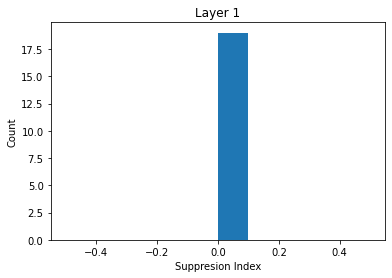

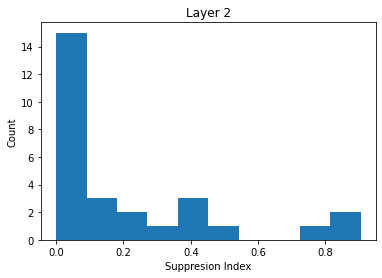

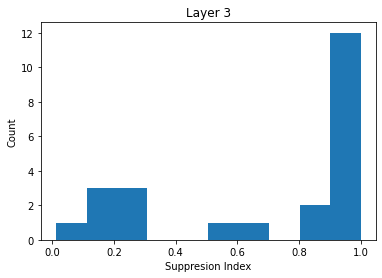

In [ ]:
actv1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# fig, ax = plt.subplots(1, 3)
plt.figure()
plt.hist(actv1)
plt.xlabel('Suppresion Index')
plt.ylabel('Count')
plt.title('Layer 1')
plt.figure()
plt.hist(activation2_suppress)
plt.xlabel('Suppresion Index')
plt.ylabel('Count')
plt.title('Layer 2')
plt.figure()
plt.hist(activation3_suppress)
plt.xlabel('Suppresion Index')
plt.ylabel('Count')
plt.title('Layer 3')

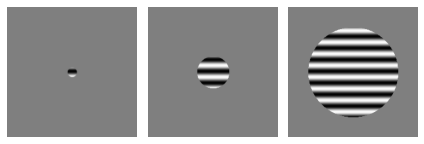

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(makeGrating(10, 20, 0, 0))
ax[0].axis("off")
ax[1].imshow(makeGrating(30, 20, 0, 0))
ax[1].axis("off")
ax[2].imshow(makeGrating(80, 20, 0, 0))
ax[2].axis("off")
plt.tight_layout()

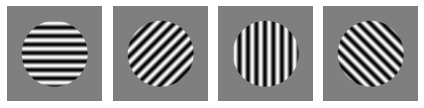

In [ ]:
fig, ax = plt.subplots(1, 4)
ax[0].imshow(makeGrating(80, 20, 0, 0))
ax[0].axis("off")
ax[1].imshow(makeGrating(80, 20, 45, 0))
ax[1].axis("off")
ax[2].imshow(makeGrating(80, 20, 90, 0))
ax[2].axis("off")
ax[3].imshow(makeGrating(80, 20, 135, 0))
ax[3].axis("off")
plt.tight_layout()

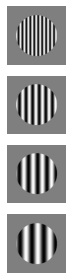

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(4, 1)
ax[0].imshow(makeGrating(80, 15, 90, 0, contrast=1))
ax[0].axis("off")
ax[1].imshow(makeGrating(80, 25, 90, 0))
ax[1].axis("off")
ax[2].imshow(makeGrating(80, 35, 90, 0))
ax[2].axis("off")
ax[3].imshow(makeGrating(80, 45, 90, 0))
ax[3].axis("off")
ax[0].axis("off")
plt.tight_layout()


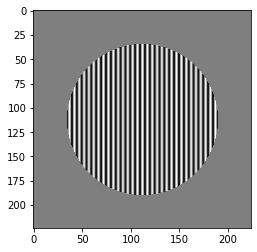

In [ ]:
imshow(makeGrating(80, 5, 90, 0, contrast=1))

In [ ]:
  phase = []
  for i in range(-180, 181, 45):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(30, sf, ori+i, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, 52]
      phase.append(n)
    print(phase)
    phase_avg = sum(phase)/len(phase)

[0.0, 0.19169904, 0.16450271, 0.07344555, 0.0, 0.021885209, 0.30966574, 0.2273528]
[0.0, 0.19169904, 0.16450271, 0.07344555, 0.0, 0.021885209, 0.30966574, 0.2273528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


KeyboardInterrupt: ignored

In [ ]:
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)
neurons = [45, 87, 101, 129, 185, 213]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  print(y1)

sf, ori = find_optimal_grating(52)
size_variation(sf, ori, 52)


[0.0, 0.0, 0.0007392206462100148, 0.20840382017195225, 0.11868497281102464, 0.17741895839571953, 0.008179992437362671, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
def ori_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(0, 316, 45):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(30, sf, i, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  print(y1)

ori_variation(sf, ori, 52)

[0.0, 0.12356888130307198, 0.0, 0.0, 0.0, 0.17741895839571953, 0.0, 0.0]


In [ ]:
outside = makeGrating(80, 10, 90, 0, contrast =1, annular=50)
inside = makeGrating(40, 10, 0, 0, imsize=40)

In [ ]:
import os
from matplotlib.pyplot import imread

def masked_texture(size, texture_class, family='13', sample_index='1', texture='Freeman', phase_scramble=False, imsize=224, sharpness=5, contrast=1, annular=0, dtype='uint8'):
    """
    Make a square grating.
    size: radius of the mask
    texture_class: index of texture class.
    texture: 'Brodatz' or 'Freeman'
    sample_index: which sample to use.
    phase_scramble: if true, use noise image.
    imsize: the image size.
    annular: inside diameter of the donut.
    sharpness: pixels of HMFW of gaussian mask.
    contrast: 0-1.
    """
    texture_folder = os.path.join(os.getcwd(),'drive/My Drive', 'model')
    image_folder = os.path.join(texture_folder, texture_class, texture_class,'D'+family,)
    if texture_class == 'naturalistic':
      image_path = os.path.join(image_folder 'tex-320x320-im'+family+'-smp'+sample_index+'.png')
    else:
      image_path = os.path.join(image_folder, 'noise-320x320-im'+family+'-smp'+sample_index+'.png')     
    im = imread(image_path).astype('float')
    (w,h) = im.shape
    # crop image
    im = im[int((w-imsize)/2):int((w+imsize)/2), int((h-imsize)/2):int((h+imsize)/2)]
    if texture=='Brodatz':
        im = im-127
    else:
        im = im-0.5
    gaussianmask = makeGaussian(imsize, size, sharpness, annular=annular)
    im = im*gaussianmask*contrast
    if texture=='Brodatz':
        im = im+127
    else:
        im = (im+0.5)*255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation').output)
  

im = np.expand_dims(np.asarray((masked_texture(50, 'naturalNoiseSamples')/127.5)-1),0)

activation_layer = intermediate_activation(im, training=False).numpy()
n = activation_layer[0, 28, 28]

print(n)




[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3966770e-01 0.0000000e+00
 8.6647344e-01 0.0000000e+00 0.0000000e+00 2.0904554e-01 4.0897477e-01
 1.3008954e-01 0.0000000e+00 5.5362892e-01 1.8147263e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9974525e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0497518e-03 1.4573732e-01 0.0000000e+00
 4.4296321e-01 0.0000000e+00 1.0050100e-01 2.5204206e-02 0.0000000e+00
 2.3289952e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.6399245e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.6812676e-01 0.0000000e+00 1.0439183e+00 0.0000000e+00 1.7585751e-01
 0.0000000e+00 0.0000000e+00 4.4624913e-01 0.0000000e+00 0.0000000e+00
 2.5331911e-01 0.0000000e+00 5.8186674e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9679841e-01
 7.944

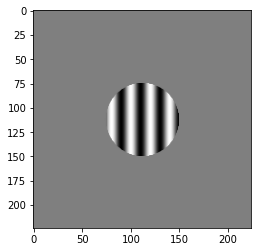

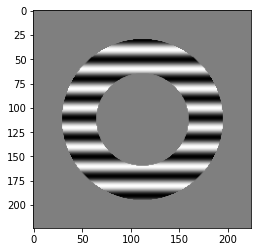

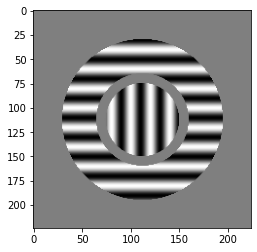

In [ ]:
therad=40
theannul=50

surr_grat = makeGrating(85, 20, 0, 0, 224, annular= theannul)
plt.figure()
imshow(surr_grat)
ctr_grat = makeGrating(therad, 20, 0+90, 0)
imshow(ctr_grat)
plt.figure()
imshow(surr_grat)
plt.figure()
thegrat=(ctr_grat-(127))+(surr_grat-(127))
imshow(thegrat+127)


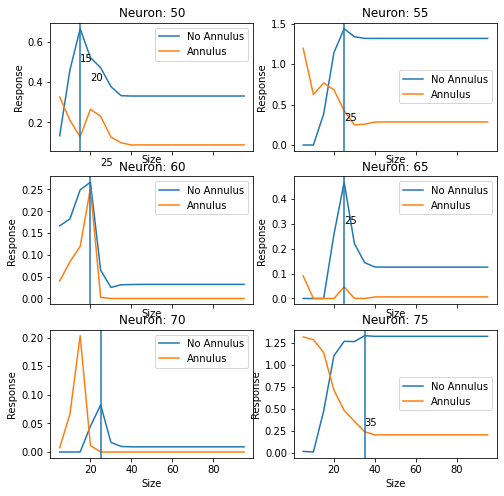

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = [50, 55, 60, 65, 70, 75]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(5, 100, 5):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(100, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  grate_idx = y1.index(max(y1))
  return x, y1, y2, grate_idx


fig, ax = plt.subplots(3, 2, sharex='col', figsize=(8, 8))
for x in range(3):
  sf, ori = find_optimal_grating(neurons[num])
  x1, y1, y2, max_y1 = size_variation(sf, ori, neurons[num])
  ax[x, count].plot(x1, y1, label = 'No Annulus')
  ax[x, count].plot(x1, y2, label = 'Annulus')
  ax[x, count].axvline(x1[max_y1])
  ax[x, count].text(x1[max_y1], 0.5, x1[max_y1])
  ax[x, count].set_xlabel("Size")
  ax[x, count].set_ylabel("Response")
  ax[x, count].legend()
  ax[x, count].set_title(f"Neuron: {neurons[num]}")
  count = 1
  num += 1
  sf, ori = find_optimal_grating(neurons[num])
  x1, y1, y2, max_y1 = size_variation(sf, ori, neurons[num])
  ax[x, count].plot(x1, y1, label = 'No Annulus')
  ax[x, count].plot(x1, y2, label = 'Annulus')
  ax[x, count].axvline(x1[max_y1])
  ax[x, count].text(x1[max_y1], 0.3, x1[max_y1])
  ax[x, count].set_xlabel("Size")
  ax[x, count].set_ylabel("Response")
  ax[x, count].legend()
  ax[x, count].set_title(f"Neuron: {neurons[num]}")
  count = 0
  num += 1
plt.savefig(f"{path}/annular_response/activation2.png")
plt.show()

In [ ]:
dict = {45: [20, 35], 55: [25, 40], 75: [35, 50]}
for i in dict:
  print(i)
  print(dict[i])

45
[20, 35]
55
[25, 40]
75
[35, 50]


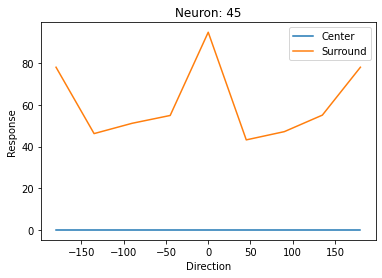

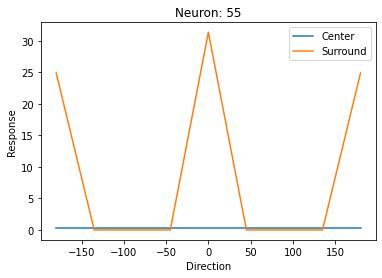

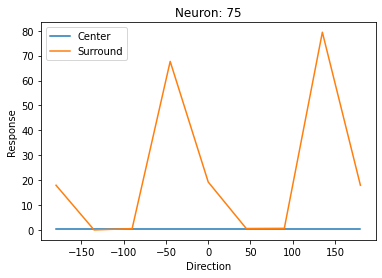

In [ ]:
import pandas as pd

neurons_dict = {45:[38, 40], 55: [38, 40], 75: [35, 50]}

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def orientation_variation(sf, ori, location, list1):
  x = []
  y1 = []
  y2 = []
  phase = []
  annul = list1[1]
  rad_in = list1[0]
  rad_out = 85
  # center alone
  for i in range(-90, 90, 15):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(rad_in, sf, ori+i, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  # surround stimuli
  for i in range(-90, 90, 15):
    for j in range(0, 316, 45):
      surr_grat = makeGrating(rad_out, sf, ori+i, j, annular= annul)
      ctr_grat = makeGrating(rad_in, sf, ori, j)
      thegrat=(ctr_grat-(127))+(surr_grat-(127))
      inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []
  return x, y1, y2

for i in neurons_dict:
  sf, ori = find_optimal_grating(i)
  x1, y1, y2 = orientation_variation(sf, ori, i,neurons_dict[i])
  plt.figure()
  plt.plot(x1, y1, label='Center')
  plt.plot(x1, y2, label='Surround')
  plt.xlabel('Direction')
  plt.ylabel('Response')
  plt.title(f"Neuron: {i}")
  plt.legend()


In [ ]:
inpt = np.expand_dims(np.asarray((makeGrating(30, 15, 35, 0)/127.5)-1),0)
activation_layer = intermediate_activation(inpt, training=False).numpy()
n = activation_layer[0, 7, 7, 45]
print(n)
inpt = np.expand_dims(np.asarray((makeGrating(30, 15, 90, 0)/127.5)-1),0)
activation_layer = intermediate_activation(inpt, training=False).numpy()
n = activation_layer[0, 7, 7, 45]
print(n)

0.12330829
0.12330829


0.14877349
0.14877349
0.14877349
0.14877349
0.14877349
0.14877349
0.14877349


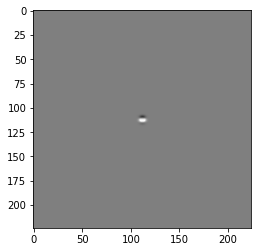

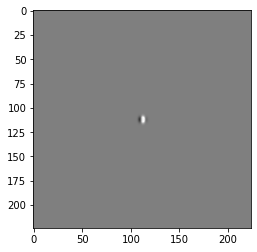

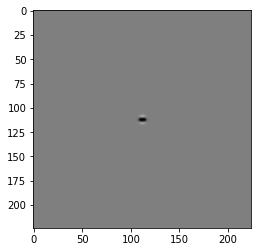

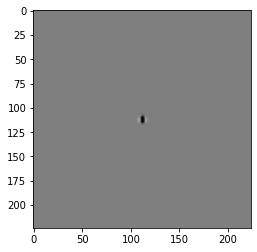

In [ ]:
for i in range(0, 315, 45):
  inpt = np.expand_dims(np.asarray((makeGrating(5, 10, i, 0)/127.5)-1),0)
  activation_layer = intermediate_activation(inpt, training=False).numpy()
  n = activation_layer[0, 14, 14, 50]
  print(n)
for i in range(0, 315, 90):
  plt.figure()
  imshow(makeGrating(5, 10, i, 0))

3
7
4
6
6
10
12


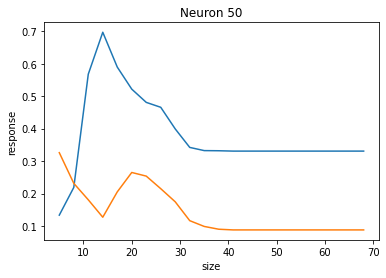

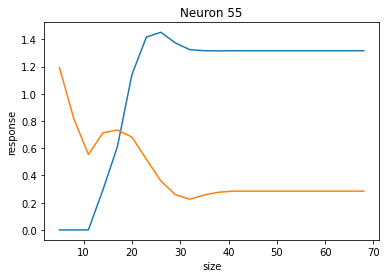

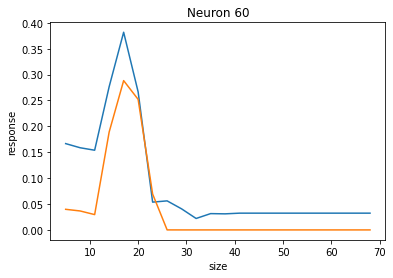

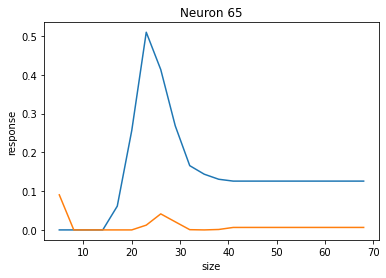

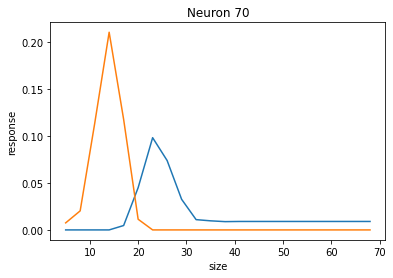

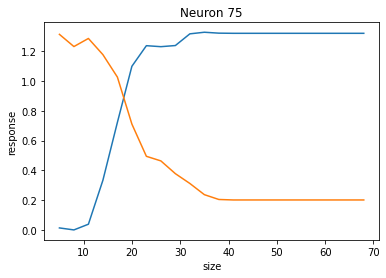

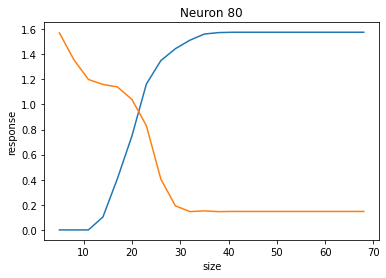

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random

x = []
y = []

count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = [50, 55, 60, 65, 70, 75, 80]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 70, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(5, 70, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(90, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  grate_idx = y1.index(max(y1))
  return x, y1, y2, grate_idx

for i in range(len(neurons)):
  sf, ori = find_optimal_grating(neurons[i])
  x, y1, y2, gsf = size_variation(sf, ori, neurons[i])
  plt.figure()
  plt.plot(x, y1)
  plt.plot(x, y2)
  plt.xlabel("size")
  plt.ylabel("response")
  plt.title(f"Neuron {neurons[i]}")




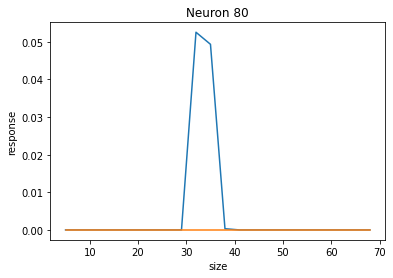

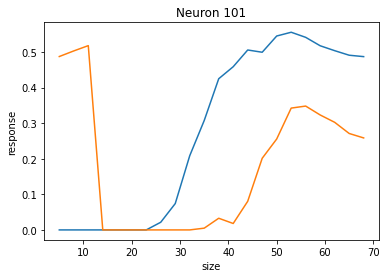

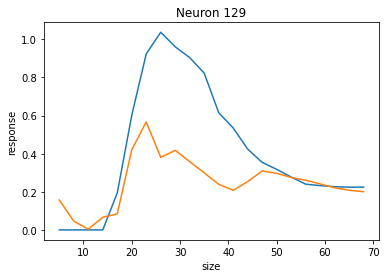

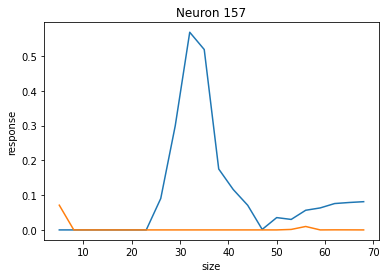

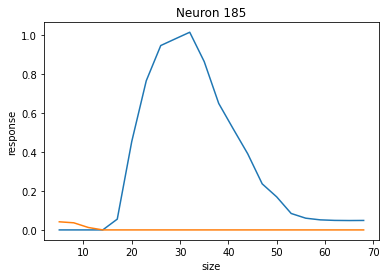

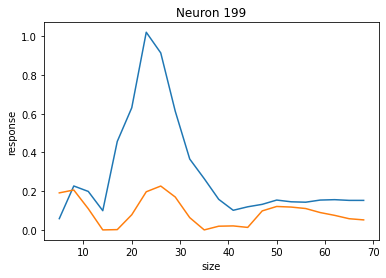

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,outputs=model.get_layer('activation_2').output)
neurons = [80, 101, 129, 157, 185, 199]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation(sf, ori, location):
  x = []
  y1 = []
  y2 = []
  phase = []
  for i in range(5, 70, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y1.append(phase_avg)
    phase = []
  for i in range(5, 70, 3):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(90, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  grate_idx = y1.index(max(y1))
  return x, y1, y2, grate_idx

for i in range(len(neurons)):
  sf, ori = find_optimal_grating(neurons[i])
  x, y1, y2, gsf = size_variation(sf, ori, neurons[i])
  plt.figure()
  plt.plot(x, y1)
  plt.plot(x, y2)
  plt.xlabel("size")
  plt.ylabel("response")
  plt.title(f"Neuron {neurons[i]}")

In [ ]:
# area summation curves
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = np.arange(0, 50).tolist()

def size_variation(neuron):
  y = []
  sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_1/{neuron}_optsti.npy')
  phase = []
  for i in range(0, 71, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(90, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y.append(phase_avg)
    phase = []
  return y

for i in range(len(neurons)):
  x, y1 = np.load(f'{path}Xu/results/diameter_tuning/dia_tuning_data/activation_1/{neurons[i]}_dia_tuning.npy')
  y2 = size_variation(neurons[i])
  x95 = [0, 70]
  y95 = [(max(y1)*0.95), (max(y1)*0.95)]
  plt.figure()
  plt.plot(x, y1)
  plt.plot(x, y2, color = 'black')
  plt.plot(x95, y95, color = 'grey', linestyle = 'dashed')
  plt.xlabel("size")
  plt.ylabel("response")
  plt.title(f"Neuron Response Neuron {neurons[i]}")
  plt.savefig(f'{path}area_summation/activation_1/{neurons[i]}_a_sum.png')
  plt.close()


In [ ]:
# area summation curves
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)
neurons = np.arange(0, 50).tolist()

def size_variation(neuron):
  y = []
  sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_2/{neuron}_optsti.npy')
  phase = []
  for i in range(0, 71, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(90, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y.append(phase_avg)
    phase = []
  return y

for i in range(len(neurons)):
  x, y1 = np.load(f'{path}Xu/results/diameter_tuning/dia_tuning_data/activation_2/{neurons[i]}_dia_tuning.npy')
  y2 = size_variation(neurons[i])
  x95 = [0, 70]
  y95 = [(max(y1)*0.95), (max(y1)*0.95)]
  plt.figure()
  plt.plot(x, y1)
  plt.plot(x, y2, color = 'black')
  plt.plot(x95, y95, color = 'grey', linestyle = 'dashed')
  plt.xlabel("size")
  plt.ylabel("response")
  plt.title(f"Neuron Response Neuron {neurons[i]}")
  plt.savefig(f'{path}area_summation/activation_2/{neurons[i]}_a_sum.png')
  plt.close()

In [ ]:
# center contrast experiment
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = np.arange(0, 20, 1).tolist()

def size_variation(neuron):
  y2 = []
  sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_1/{neuron}_optsti.npy')
  phase = []
  for i in range(0, 71, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(80, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  x, y1 = np.load(f'{path}Xu/results/diameter_tuning/dia_tuning_data/activation_1/{neuron}_dia_tuning.npy')
  chk1 = max(y1)*0.95
  for i in range(len(y1)):
    if y1[i] > chk1:
      gsf = x[i]
  chk2 = ((max(y2)-min(y2)*0.05)+min(y2))
  for i in range(len(y2)):
    if y2[i] < chk2:
      amrf = x[i]

  if amrf - gsf > 15:
    amrf = gsf + 10
  elif amrf - gsf < 5:
    amrf = gsf + 10
  return gsf, amrf

def center_contrast(rad_in, rad_out, neuron):
  ctr_only = []
  preferred = []
  orthog = []
  phase = []
  sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_1/{neuron}_optsti.npy')

  # Center alone
  contr = np.arange(0.1, 1.05, 0.05).tolist()
  for i in range(len(contr)):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(rad_in, sf, ori, j, contrast = contr[i])/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    ctr_only.append(phase_avg)
    phase = []      
  # Preferred
  for i in range(len(contr)):
    for j in range(0, 316, 45):
      surr_grat = makeGrating(80, sf, ori, j, annular= rad_out)
      ctr_grat = makeGrating(rad_in, sf, ori, j, contrast = i)
      thegrat=(ctr_grat-(127))+(surr_grat-(127))
      inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    preferred.append(phase_avg)
    phase = []
  # Orthogonal
  for i in range(len(contr)):
    for j in range(0, 316, 45):
      surr_grat = makeGrating(80, sf, ori+90, j, annular= rad_out)
      ctr_grat = makeGrating(rad_in, sf, ori, j, contrast = i)
      thegrat=(ctr_grat-(127))+(surr_grat-(127))
      inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    orthog.append(phase_avg)
    phase = []

  return ctr_only, preferred, orthog

for i in range(len(neurons)):
  x = np.arange(0.1, 1.05, 0.05)
  rad_in, rad_out = size_variation(neurons[i])
  ctr_only, preferred, orthog = center_contrast(rad_in, rad_out, neurons[i])
  plt.figure()
  plt.plot(x, ctr_only)
  plt.savefig(f'{path}center_contrast/activation_1/{neurons[i]}_center.png')
  plt.plot(x, preferred)
  plt.plot(x, orthog)
  plt.title(f"Neuron {neurons[i]}")
  plt.savefig(f'{path}center_contrast/activation_1/{neurons[i]}_periph.png')

# x = np.arange(0.1, 1.1, 0.1)
# rad_in, rad_out = size_variation(9)
# ctr_only, preferred, orthog = center_contrast(rad_in, rad_out, 9)
# plt.figure()
# plt.plot(x, ctr_only)
# plt.plot(x, preferred)
# plt.plot(x, orthog)
# plt.show()


UnboundLocalError: ignored

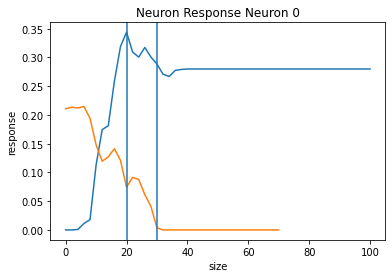

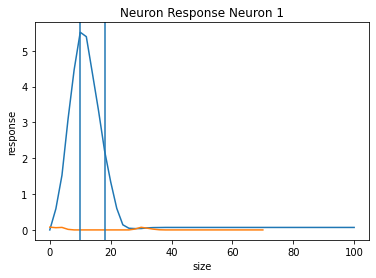

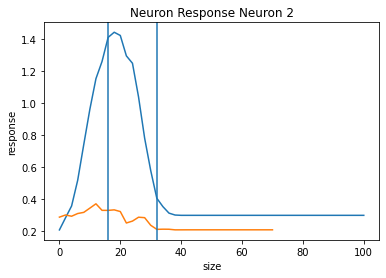

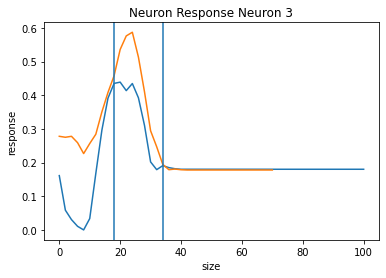

In [ ]:
#automate annular radius

import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = np.arange(0, 50, 1).tolist()
df = pd.DataFrame(columns = ['Neuron', 'GSF', 'AMRF'])
df2 = pd.DataFrame(columns = ['Neuron', 'Preferred', 'Orthogonal'])

def size_variation(neuron):
  y2 = []
  sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_1/{neuron}_optsti.npy')
  phase = []
  for i in range(0, 71, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(80, sf, ori, j, annular = i)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    y2.append(phase_avg)
    phase = []

  x2 = np.arange(0, 71, 2).tolist()
  x1, y1 = np.load(f'{path}Xu/results/diameter_tuning/dia_tuning_data/activation_1/{neuron}_dia_tuning.npy')
  done = False
  chk1 = ((max(y1)-min(y1))*0.95)+min(y1)
  for i in range(len(y1)):
    if y1[i] > chk1:
      while(not done):
        gsf = x1[i]
        gsf_response = y1[i]
        done = True
  
  done = False
  
  chk2 = ((max(y2)-min(y2))*0.05)+min(y2)
  for i in range(len(y2)):
    if y2[i] < chk2:
      while(not done):
        amrf = x2[i]
        amrf_response = y2[i]
        if amrf < gsf:
          amrf = gsf + 8
          amrf_response = y2[i]
        done = True
  
  return x1, x2, y1, y2, gsf, amrf, chk2, sf, ori

def orthogonal_test(neuron, sf, ori, rad_in, rad_out):
  phase = []
  for j in range(0, 316, 45):
    surr_grat = makeGrating(80, sf, ori, j, annular= rad_out)
    ctr_grat = makeGrating(rad_in, sf, ori, j, contrast = i)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 14, 14, neuron]
    phase.append(n)
  phase_avg_pref = sum(phase)/len(phase)

  phase = []
  for j in range(0, 316, 45):
    surr_grat = makeGrating(80, sf, ori+90, j, annular= rad_out)
    ctr_grat = makeGrating(rad_in, sf, ori, j, contrast = i)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 14, 14, neuron]
    phase.append(n)
  phase_avg_orth = sum(phase)/len(phase)

  return phase_avg_pref, phase_avg_orth

for i in range(len(neurons)):
  x1, x2, y1, y2, gsf, amrf, chk2, sf, ori = size_variation(neurons[i])
  plt.figure()
  plt.plot(x1, y1)
  plt.plot(x2, y2)
  plt.axvline(x = gsf)
  plt.axvline(x = amrf)
  plt.xlabel("size")
  plt.ylabel("response")
  plt.title(f"Neuron Response Neuron {neurons[i]}")
  plt.savefig(f'{path}annular_response_field/activation_1/area_summation_curves/neuron_{neurons[i]}.png')
  np.save(f'{path}annular_response_field/activation_1/annular_grating_results/neuron_{neurons[i]}.npy', y2)
  df = df.append({'Neuron': neurons[i], 'GSF' : gsf, 'AMRF' : amrf}, ignore_index= True)
  pref, orth = orthogonal_test(neurons[i], sf, ori, gsf, amrf)
  df2 = df2.append({'Neuron': neurons[i], 'Preferred' : gsf, 'Orthogonal' : amrf}, ignore_index= True)

print(df)
print(df2)
plt.figure()
plt.plot(df2['Preffered'], df2['Orthogonal'])

In [ ]:
  for j in range(0, 316, 45):
    surr_grat = makeGrating(80, sf, ori, j, annular= rad_out)
    ctr_grat = makeGrating(rad_in, sf, ori, j, contrast = i)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 14, 14, neuron]
    phase.append(n)
  phase_avg = sum(phase)/len(phase)
  preferred.append(phase_avg)
    phase = []
  for j in range(0, 316, 45):
      surr_grat = makeGrating(80, sf, ori+90, j, annular= rad_out)
      ctr_grat = makeGrating(rad_in, sf, ori, j, contrast = i)
      thegrat=(ctr_grat-(127))+(surr_grat-(127))
      inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 14, 14, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    orthog.append(phase_avg)
    phase = []

In [ ]:
done = False
chk1 = ((max(y1)-min(y1))*0.95)+min(y1)
while(not done):
  for i in range(len(y1)):
    if y1[i] > chk1:
      gsf = x1[i]
      done = True

print(y1, chk1, gsf)

NameError: ignored

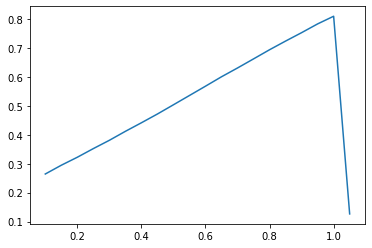

In [ ]:
plt.plot(x, ctr_only)

In [ ]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
orthog

[0.3323303908109665]

32.264378

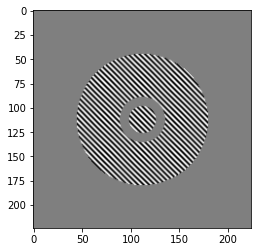

In [ ]:
surr_grat = makeGrating(70, 4, 135, 100, annular= rad_out)
ctr_grat = makeGrating(rad_in, 4, 135, 100, contrast = 1)
thegrat=(ctr_grat-(127))+(surr_grat-(127))
inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)

imshow(thegrat+127)

activation_layer = intermediate_activation(inpt, training=False).numpy()
n = activation_layer[0, 14, 14, 9]

n



In [ ]:
orthog = []
phase = []
sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_1/9_optsti.npy')

contr = np.arange(0.1, 1.1, 0.05).tolist()

for i in range(len(contr)):
  for j in range(0, 316, 45):
    surr_grat = makeGrating(90, 4, 135+90, 0, annular= rad_out)
    ctr_grat = makeGrating(rad_in, 4, 135, 0, contrast = i)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 14, 14, 9]
    phase.append(n)
  phase_avg = sum(phase)/len(phase)
  orthog.append(phase_avg)
  phase = []

orthog

[0.0,
 63.5522575378418,
 0.0,
 37.72743606567383,
 0.0,
 42.110111236572266,
 19.54073715209961,
 11.243793487548828,
 19.302690505981445,
 29.151885986328125,
 0.0,
 9.626338958740234,
 37.226749420166016,
 0.0,
 0.0,
 0.0,
 14.107414245605469,
 11.56599235534668,
 0.0,
 5.803465843200684]

In [ ]:
preferred = []
phase = []
sf, ori = np.load(f'{path}Xu/results/optimal_sti/activation_1/9_optsti.npy')

contr = np.arange(0.1, 1.1, 0.05).tolist()

for i in range(len(contr)):
  for j in range(0, 316, 45):
    surr_grat = makeGrating(90, 4, 135, 0, annular= rad_out)
    ctr_grat = makeGrating(rad_in, 4, 135, 0, contrast = i)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 14, 14, 9]
    phase.append(n)
  phase_avg = sum(phase)/len(phase)
  preferred.append(phase_avg)
  phase = []

preferred

[0.0,
 41.04191589355469,
 0.0,
 16.096256256103516,
 0.0,
 18.919349670410156,
 0.0,
 0.0,
 0.0,
 5.701325416564941,
 0.0,
 0.0,
 14.865608215332031,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

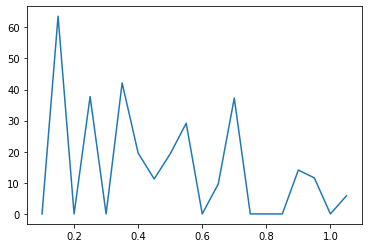

In [ ]:
plt.plot(contr, orthog)

In [ ]:
if rad_out - rad_in > 15:
  print("yes")

yes


In [ ]:
inpt = np.expand_dims(np.asarray((makeGrating(90, sf, ori, 90, annular = 5)/127.5)-1),0)

In [ ]:
lst = np.arange(0, 50).tolist()
for i in range(len(lst)):
  print(lst[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
import numpy as np

act1n1 = np.load('/content/drive/My Drive/model/Xu/results/diameter_tuning/dia_tuning_data/activation/1_dia_tuning.npy')

In [ ]:
o1, o2 = np.load('/content/drive/My Drive/model/Xu/results/optimal_sti/activation/1_optsti.npy')
o2

165.0

In [ ]:
max(act1n1[1])

0.76554836332798

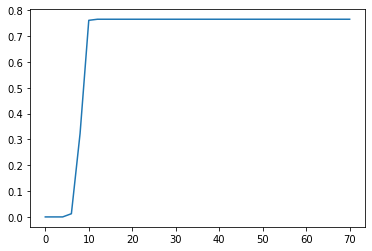

In [ ]:
import matplotlib.pyplot as plt


plt.plot(act1n1[0], act1n1[1])

In [ ]:
np.arange(0, 70, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68])

In [ ]:
print(f"neurons {neurons[3]}")

neurons 65


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

x = []
y = []

count = 0
num = 0
path = '/content/drive/My Drive/model/'
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
neurons = [50, 55, 60, 65, 70, 75]

def find_optimal_grating(location):
  df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def orthongonal_stimuli(sf, ori, location):
  y1 = 0
  y2 = 0
  phase = []
  for j in range(0, 316, 45):
    surr_grat = makeGrating(85, sf, ori, j, annular= 35)
    ctr_grat = makeGrating(25, sf, ori, j)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 7, 7, location]
    phase.append(n)
  y1 = sum(phase)/len(phase)
  
  for j in range(0, 316, 45):
    surr_grat = makeGrating(85, sf, ori+90, j, annular= 35)
    ctr_grat = makeGrating(25, sf, ori, j)
    thegrat=(ctr_grat-(127))+(surr_grat-(127))
    inpt = np.expand_dims(np.asarray((thegrat+127)-1),0)
    activation_layer = intermediate_activation(inpt, training=False).numpy()
    n = activation_layer[0, 7, 7, location]
    phase.append(n)
  y2 = sum(phase)/len(phase)
  return y1, y2

for i in neurons:
  sf, ori = find_optimal_grating(i)
  non_orth, orth = orthongonal_stimuli(sf, ori, i)
  x.append(non_orth)
  y.append(orth)

In [ ]:
import seaborn as sns

path = '/content/drive/My Drive/model/'

df = pd.read_csv(f'/content/drive/My Drive/model/activation2_heatmapdata/neuron{location}.csv')

[0.0, 31.375676423311234, 0.0, 0.0, 0.0, 18.131733417510986] [9.362667441368103, 15.687838211655617, 0.0, 0.0, 0.0, 9.437935173511505]


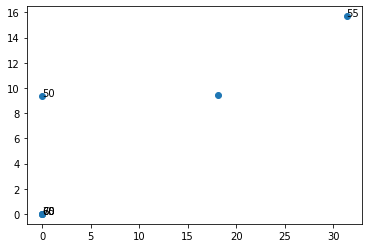

In [ ]:
print(x, y)
plt.figure()
plt.scatter(x, y)
for i in range(5):
  plt.text(x[i], y[i], neurons[i])

In [ ]:
print(np.arange(-180, 181, 45))

[-180 -135  -90  -45    0   45   90  135  180]


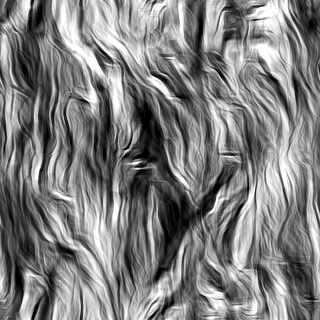

In [ ]:
im = Image.open('/content/drive/My Drive/model/naturalNoiseSamples/naturalNoiseSamples/tex-320x320-im13-smp1.png')
im

# New Section

KeyboardInterrupt: ignored

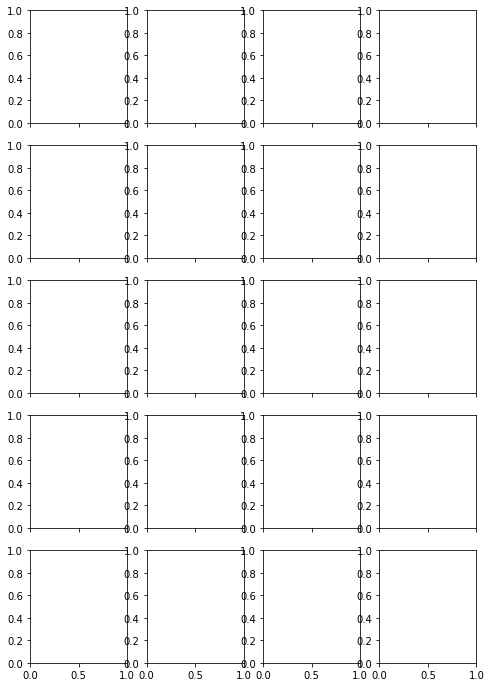

In [ ]:
count = 0
num = 0
path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))
nerons = np.arange(0, 250, 50).tolist()

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('max_pooling2d_1').output)
def find_optimal_grating(location):
  l=0
  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((saved[l]/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, 7, 7, location]
        phase.append(n)
        l+=1
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori'], heatmap_data

def size_variation(sf, ori, location):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, sf, ori, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, 7, 7, location]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)

  idx = y.index(max(y))
  return x[idx], x, y

fig, ax = plt.subplots(5, 4, sharex='col', figsize=(8, 12))
for x in range(5):
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    num += 1
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count = 0
    num += 1
plt.tight_layout()
plt.show()
plt.savefig(f"{path}/layer_response/maxpooling2.png")

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

path = '/content/drive/My Drive/model/'
saved = np.load(os.path.join(path,'sharp_edge_grating.npy'))

intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_2').output)

def df_output(neuron):
  l = 0
  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((saved[l]/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, 7, 7, neuron]
        phase.append(n)
        l += 1
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  df.to_csv(f'/content/drive/My Drive/model/activation3_heatmapdata/neuron{neuron}.csv')

for x in range(10, 361, 7):
  df_output(x)

In [ ]:
p = 0
for x in range(17, 353, 14):
  print(x)
  p += 1
print(p)

17
31
45
59
73
87
101
115
129
143
157
171
185
199
213
227
241
255
269
283
297
311
325
339
24


In [ ]:
num=0
count=0
nerons = np.arange(0, 380, 76).tolist()
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer('activation_1').output)
fig, ax = plt.subplots(5, 4, sharex='col', figsize=(8, 12))
for x in range(5):
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    num += 1
    sf, ori, pivot_data = find_optimal_grating(nerons[num])
    sns.heatmap(pivot_data, ax=ax[x, count])
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count += 1
    max_size, x1, y1 = size_variation(sf, ori, nerons[num])
    ax[x, count].plot(x1, y1)
    ax[x, count].set_title(f"Neuron: {nerons[num]}")
    count = 0
    num += 1
plt.tight_layout()
plt.show()
plt.savefig(f"{path}/layer_response/activation2.png")

NameError: ignored

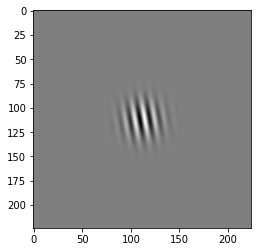

In [ ]:
from matplotlib.pyplot import imshow

inpt = np.asarray(makeGrating(30, 10, 100, 100))
imshow(inpt, cmap='gray')

inpt = np.expand_dims(np.asarray((makeGrating(30, 10, 100, 100)/127.5)-1),0)

activation_layer = intermediate_activation(inpt, training=False).numpy()

np.max(activation_layer)
imshow(activation_layer[0,:,:,50])

In [ ]:
def return_row():
  return df[df.Average_phase==df.Average_phase.max()] 

ans = return_row()
print(ans)

       Sf    Ori  Average_phase
191  50.0  315.0       8.846139


In [ ]:
model.predict(grating)

array([[1.00227783e-06, 2.34908724e-11, 2.20225973e-11, 6.04233774e-09,
        8.08628858e-11, 1.59344142e-12, 1.80782694e-10, 8.19517544e-12,
        1.61182101e-09, 6.36850087e-11, 1.54402630e-10, 1.92517322e-11,
        3.42752955e-08, 9.82533876e-09, 8.06942967e-12, 7.37626360e-09,
        7.72501085e-09, 3.19336169e-10, 2.56924603e-12, 3.88297172e-09,
        2.81734325e-09, 9.08197129e-11, 3.18066036e-08, 1.28653710e-09,
        2.87268104e-12, 5.93296701e-09, 3.41666170e-12, 1.13173173e-05,
        1.20745939e-11, 1.45491807e-09, 1.40467060e-09, 1.67211724e-07,
        8.45096171e-09, 8.61326407e-05, 1.09431710e-06, 1.41773038e-09,
        1.35447174e-11, 6.39204378e-09, 1.42885971e-14, 1.48805244e-08,
        8.69448818e-11, 1.38880640e-09, 1.45662887e-12, 3.30650868e-10,
        1.14559811e-08, 1.57521328e-07, 3.73216319e-11, 1.20264376e-08,
        9.56322521e-11, 3.29462777e-11, 2.81217467e-08, 1.35480678e-12,
        3.10291487e-10, 1.11806764e-09, 2.57721166e-12, 4.062481

# VGG Model

In [ ]:
vgg_model = tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

vgg_model.summary()

574726144/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
convolution: Kernel filter = 3x3, stride = 1
max pooling: kernel filter= 2x2, stride = 2 

conv1: 1 + (3-1)*1 = 3
conv2: 3 + (3-1)*1 = 5
max_pool1: 5 + (2-1)*2 = 7
conv3: 7 + (3-1)*2 = 11
conv4: 11 + (3-1)*2 = 15
max_pool2: 15 + (2-1)*4 = 19
conv5: 19 + (3-1)*4 = 27
conv6: 27 + (3-1)*4 = 35
conv7: 35 + 8 = 43
conv8: 43 + 8 = 51


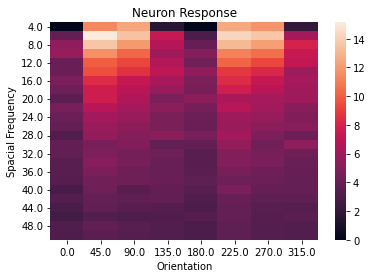

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

intermediate_activation = tf.keras.Model(inputs=vgg_model.input,
                                                  outputs=vgg_model.get_layer('block2_conv1').output)


def find_optimal_grating(d1, d2, d3):

  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((makeGrating(11, i, j, k)/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, d1, d2, d3]
        phase.append(n)
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  ax = sns.heatmap(heatmap_data)
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation_response(freq, orient, d1, d2, d3):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, d1, d2, d3]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  plt.plot(x, y)
  plt.xlabel("size")
  plt.ylabel("reponse")
  plt.show()

sf1, ori1 = find_optimal_grating(56, 56, 10)
    

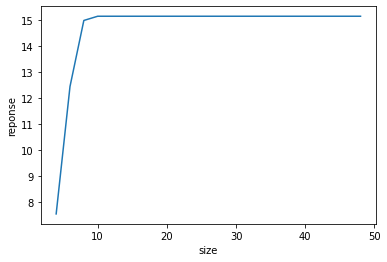

In [ ]:
def size_variation_response(freq, orient, d1, d2, d3):
  x = []
  y = []
  phase = []
  for i in range(4, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, d1, d2, d3]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  plt.plot(x, y)
  plt.xlabel("size")
  plt.ylabel("reponse")
  plt.show()

size_variation_response(sf1, ori1, 56, 56, 10)

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure

import sys
sys.path.insert(1, '/content/drive/MyDrive/Annie/model/Xu')
#from grating_util import makeGaussian, makeGrating

import time

import seaborn as sns
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mean = [103.939, 116.779, 123.68]
std = [58.393, 57.12, 57.375]
size = 30 # set grating diameter

model =  tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
    )

def generate_heatmap_data(ctr_lyr, neuron):
  df = pd.DataFrame(columns=['Spacial_Frequency', 'Orientation', 'Avg_Response_Over_Phases'])
  phase = []
  # size = 30 # set grating diameter
  l = 0
  for i in range(4, 51, 2): # spacial frequency
    for j in range(0, 166, 15): # orientation
      for k in range(0, 316, 45): # phase
        activation_layer = intermediate_activation(saved[l], training=False).numpy()
        n = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
        phase.append(n)
        l += 1
      phase_avg = sum(phase)/len(phase) # average of phase
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []
  return df

def find_optimal_grating(df):
  filtered =  df[df.Avg_Response_Over_Phases==df.Avg_Response_Over_Phases.max()] # new dataframe with row where average response is highest
  return filtered.iloc[0]['Spacial_Frequency'], filtered.iloc[0]['Orientation']

In [ ]:
def increase_grating_size(freq, orient, ctr_lyr, neuron, contrast=1.0, shift=0):
  x = []
  y = []
  phase = []
  for i in range(4, 101, 1): # size
    for j in range(0, 316, 45): # phase
      im = makeGrating(i, freq, orient, j)
      im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
      im = np.moveaxis(im,0,-1)
      inpt = np.expand_dims(im,0)
      inpt = inpt*contrast
      # inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i) # list of grating size
    y.append(phase_avg) # list of average neuron reponse over phases
    phase = []

  return x, y

block3_conv1: 2
block3_conv1: 3
block3_conv1: 4
block3_conv1: 5


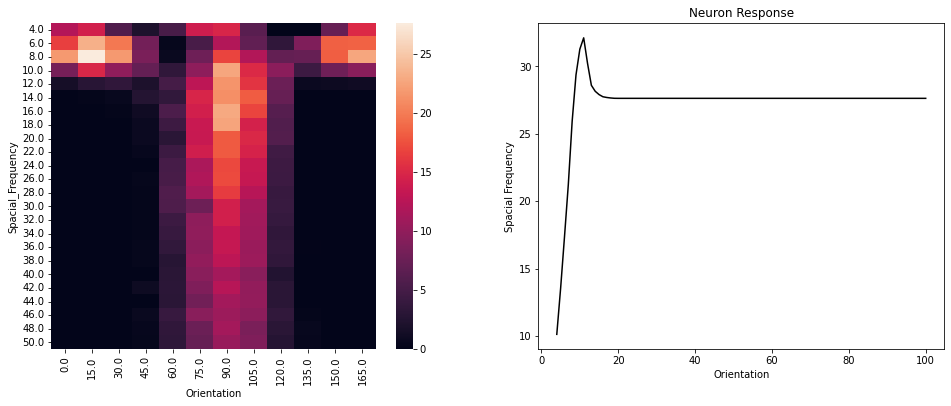

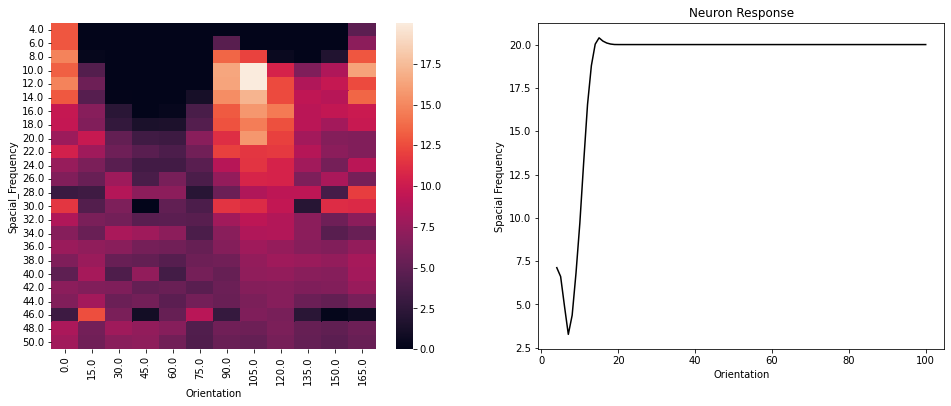

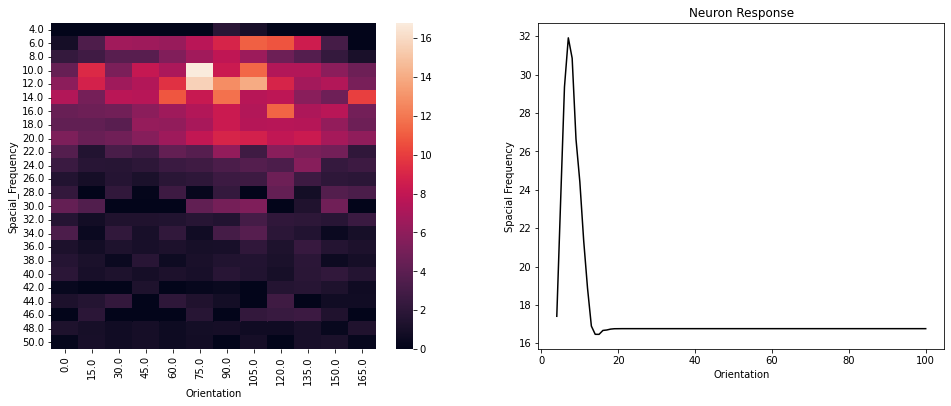

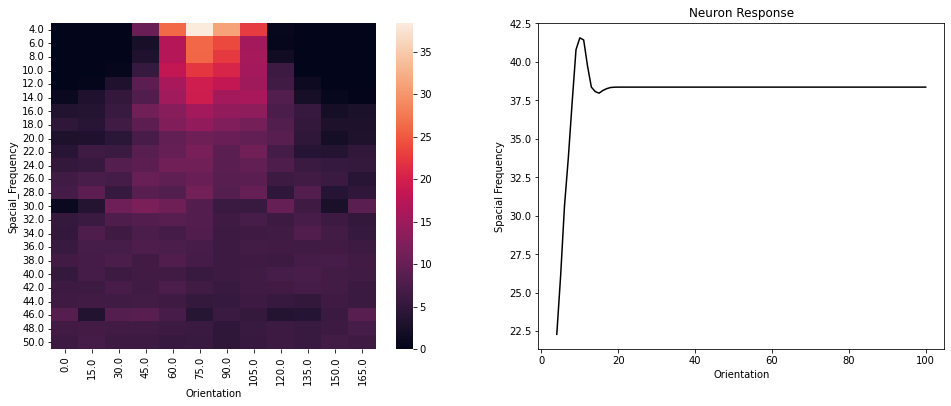

In [ ]:


layer = "block3_conv1"
intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer(layer).output)
ctr_lyr = int(model.get_layer(layer).output_shape[1]/2)
shift = int((224/model.get_layer(name=layer).output_shape[1])/2)

t = time.time()
mean = [103.939, 116.779, 123.68]
std = [58.393, 57.12, 57.375]
# if layer == 'activation':
#   size = int(11*0.7/2) # changed from 0.7 to 0.5
# elif layer == 'activation_1':
#   size = int(51*0.7/2)
# elif layer == 'activation_2':
#   size = int(99*0.7/2)
# elif layer == 'activation_3':
#   size = int(131*0.7/2)
# elif layer == 'activation_4':
#   size = int(163*0.7/2)  
#   # size = 30 # set grating diameter
size = 27
# saved = []
# for i in range(4, 51, 2): # spacial frequency
#   for j in range(0, 166, 15): # orientation
#     for k in range(0, 316, 45): # phase
#       im = makeGrating(size, i, j, k)
#       im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
#       im = np.moveaxis(im,0,-1)
#       inpt = np.expand_dims(im,0)
#       saved.append(inpt)
#   # np.save('/content/drive/MyDrive/Annie/model/Xu/gratings_for_heatmap.npy',np.array(gratings_for_heatmap))
# print(time.time()-t)

neuron_list = [2, 3, 4, 5]
for neuron in neuron_list:
  print(layer+': '+str(neuron))
    # heatmap data
  hm_data = generate_heatmap_data(ctr_lyr, neuron) # this function uses "saved"
  hm_data.to_csv(f'/content/drive/MyDrive/model/VGG/results_50radius/heatmap/data/{neuron}_heatmap.csv')
    # heatmap plot
  hm_pivot = pd.pivot_table(hm_data, values='Avg_Response_Over_Phases', index=['Spacial_Frequency'], columns='Orientation')
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))

  sns.heatmap(hm_pivot, ax=ax[0])
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  plt.savefig(f'/content/drive/MyDrive/model/VGG/results_50radius/heatmap/img/{neuron}_heatmap.png')

    
    # optimal stimulus
  sf, ori = find_optimal_grating(hm_data)
  np.save(f"/content/drive/MyDrive/model/VGG/results_50radius/optimal_sti/{neuron}_optsti.npy", np.asarray([sf, ori]))
    
    # diamieter tuning curve data
  sizes, responses = increase_grating_size(sf, ori, ctr_lyr, neuron, shift=shift)
  np.save(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_data/{neuron}_dia_tuning.npy", np.asarray([sizes, responses]))

    # diamieter tuning curve plot
  plt.plot(sizes, responses, color='black')
  plt.savefig(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_plot/{neuron}_dia_tuning.png")

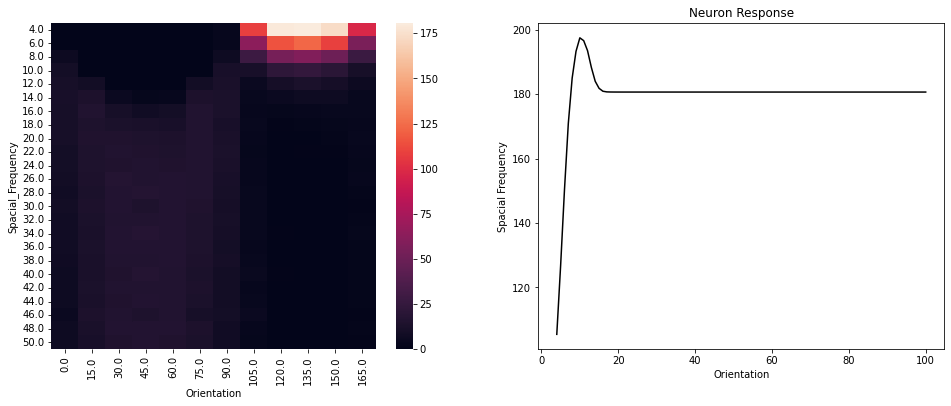

In [ ]:
  # hm_data = generate_heatmap_data(ctr_lyr, neuron) # this function uses "saved"
  hm_data.to_csv(f'/content/drive/MyDrive/model/VGG/results_50radius/heatmap/data/{neuron}_heatmap.csv')
    # heatmap plot
  hm_pivot = pd.pivot_table(hm_data, values='Avg_Response_Over_Phases', index=['Spacial_Frequency'], columns='Orientation')
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))

  sns.heatmap(hm_pivot, ax=ax[0])
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  plt.savefig(f'/content/drive/MyDrive/model/VGG/results_50radius/heatmap/img/{neuron}_heatmap.png')

    
    # optimal stimulus
  sf, ori = find_optimal_grating(hm_data)
  np.save(f"/content/drive/MyDrive/model/VGG/results_50radius/optimal_sti/{neuron}_optsti.npy", np.asarray([sf, ori]))
    
    # diamieter tuning curve data
  sizes, responses = increase_grating_size(sf, ori, ctr_lyr, neuron, shift=shift)
  np.save(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_data/{neuron}_dia_tuning.npy", np.asarray([sizes, responses]))

    # diamieter tuning curve plot
  plt.plot(sizes, responses, color='black')
  plt.savefig(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_plot/{neuron}_dia_tuning.png")

In [ ]:
saved = []
for i in range(4, 51, 2): # spacial frequency
  for j in range(0, 166, 15): # orientation
    for k in range(0, 316, 45): # phase
      im = makeGrating(size, i, j, k)
      im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
      im = np.moveaxis(im,0,-1)
      inpt = np.expand_dims(im,0)
      saved.append(inpt)
  # np.save('/content/drive/MyDrive/Annie/model/Xu/gratings_for_heatmap.npy',np.array(gratings_for_heatmap))

block3_conv1: 0
block3_conv1: 1


KeyboardInterrupt: ignored

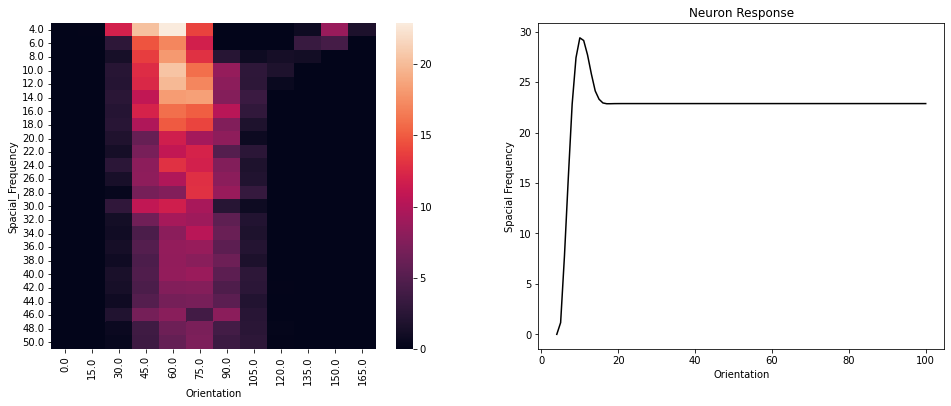

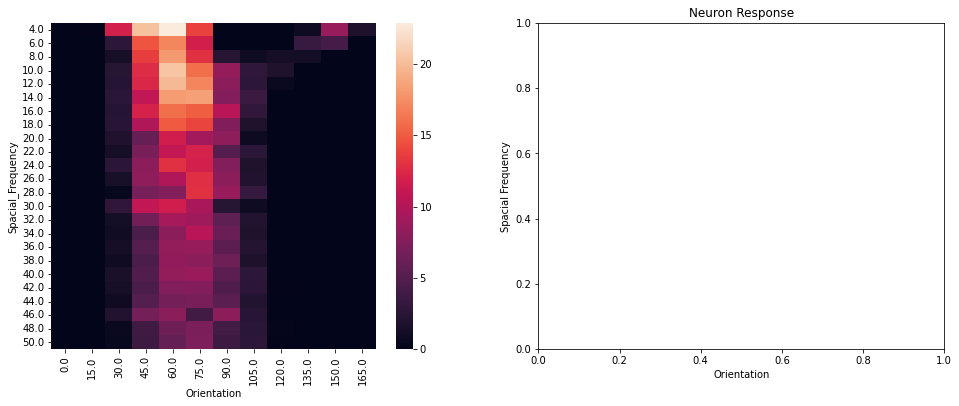

In [ ]:
for neuron in range(len(neurons)):
  print(layer+': '+str(neuron))
    # heatmap data
  #hm_data = generate_heatmap_data(ctr_lyr, neuron) # this function uses "saved"
  hm_data.to_csv(f'/content/drive/MyDrive/model/VGG/results_50radius/heatmap/data/{neuron}_heatmap.csv')
    # heatmap plot
  hm_pivot = pd.pivot_table(hm_data, values='Avg_Response_Over_Phases', index=['Spacial_Frequency'], columns='Orientation')
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))

  sns.heatmap(hm_pivot, ax=ax[0])
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  plt.savefig(f'/content/drive/MyDrive/model/VGG/results_50radius/heatmap/img/{neuron}_heatmap.png')

    
    # optimal stimulus
  sf, ori = find_optimal_grating(hm_data)
  np.save(f"/content/drive/MyDrive/model/VGG/results_50radius/optimal_sti/{neuron}_optsti.npy", np.asarray([sf, ori]))
    
    # diamieter tuning curve data
  sizes, responses = increase_grating_size(sf, ori, ctr_lyr, neuron, shift=shift)
  np.save(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_data/{neuron}_dia_tuning.npy", np.asarray([sizes, responses]))

    # diamieter tuning curve plot
  plot(sizes, responses, color='black')
  plt.savefig(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_plot/{neuron}_dia_tuning.png")

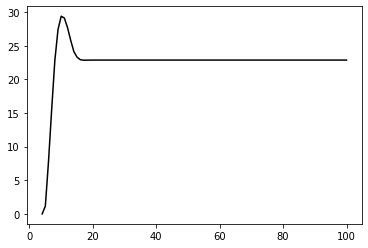

In [ ]:
plt.plot(sizes, responses, color='black')
plt.savefig(f"/content/drive/MyDrive/model/VGG/results_50radius/diameter_tuning/dia_tuning_plot/{neuron}_dia_tuning.png")

In [ ]:
intermediate_layer_activation_model = keras.Model(inputs=vgg_model.input, outputs=vgg_model.get_layer(index=index).output)

To find optimal sf & ori for each neuron.\
first try activation1 alexnet.

for sf(cpp(circle per pixel) 1/50:20 steps:1/4)\
    for ori in 0:45:315\
        for phase in 0:45:315\
        average across phase\
find sf ori that maximum activation for each neuron (try 10 neuron first).

for each neuron at its prefered sf and ori, plot the surrounding modulation (average phase).

for size = 2:1:40